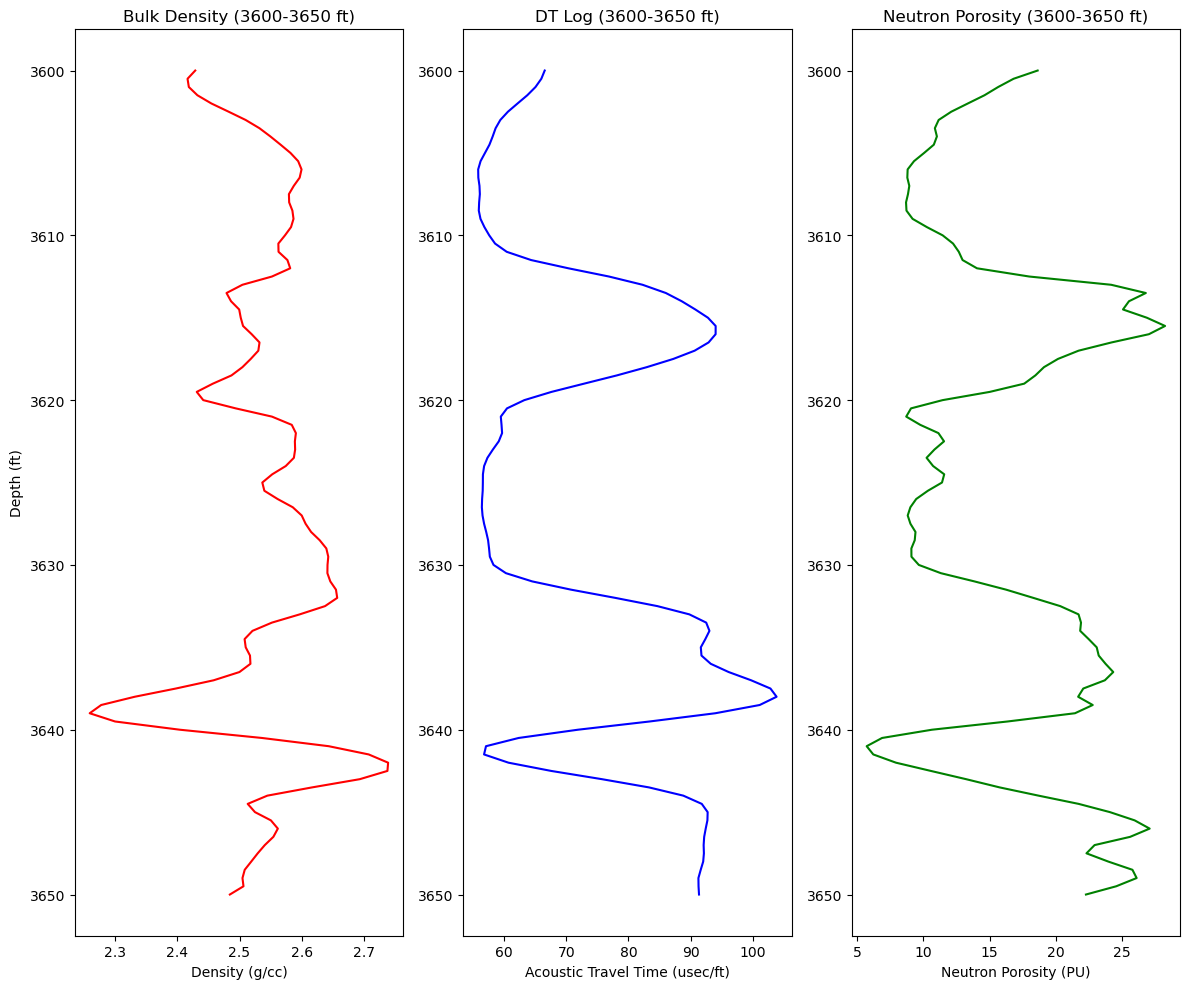

In [1]:
import lasio
import numpy as np
import matplotlib.pyplot as plt

# Load LAS file
las = lasio.read("1054146917.las")

# Extract relevant logs
depth = las["DEPT"]  # Depth in ft
density = las["RHOB"]  # Bulk Density (g/cc)
dt = las["DT"]  # Acoustic Travel Time (usec/ft)
cnpor = las["CNPOR"]  # Neutron Porosity (PU)

# Remove NaN values
valid_idx = ~np.isnan(density) & ~np.isnan(dt) & ~np.isnan(cnpor)
depth, density, dt, cnpor = depth[valid_idx], density[valid_idx], dt[valid_idx], cnpor[valid_idx]

# Filter data for the depth range 3600 - 3650 ft
depth_mask = (depth >= 3600) & (depth <= 3650)
depth_filtered = depth[depth_mask]
density_filtered = density[depth_mask]
dt_filtered = dt[depth_mask]
cnpor_filtered = cnpor[depth_mask]

# Plot raw data for the selected depth range
plt.figure(figsize=(12, 10))

plt.subplot(131)
plt.plot(density_filtered, depth_filtered, 'r')
plt.xlabel("Density (g/cc)"); plt.ylabel("Depth (ft)"); plt.gca().invert_yaxis()
plt.title("Bulk Density (3600-3650 ft)")

plt.subplot(132)
plt.plot(dt_filtered, depth_filtered, 'b')
plt.xlabel("Acoustic Travel Time (usec/ft)")
plt.gca().invert_yaxis()
plt.title("DT Log (3600-3650 ft)")

plt.subplot(133)
plt.plot(cnpor_filtered, depth_filtered, 'g')
plt.xlabel("Neutron Porosity (PU)")
plt.gca().invert_yaxis()
plt.title("Neutron Porosity (3600-3650 ft)")

plt.tight_layout()
plt.show()


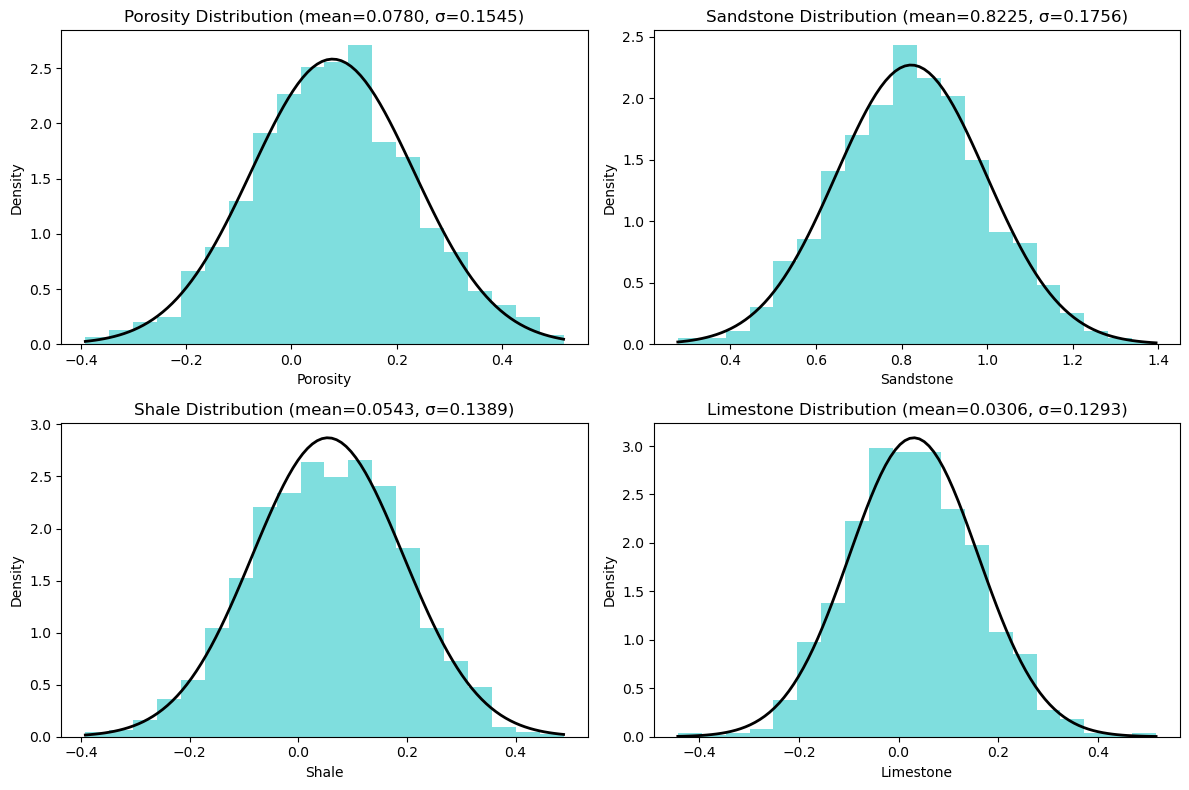

In [3]:
# Parameters from Table 2 of the paper: [porosity, sandstone, shale, limestone]
core_means = np.array([0.0851, 0.8200, 0.0618, 0.0330])
core_vars = np.array([0.0245, 0.0329, 0.0212, 0.0162])
core_stds = np.sqrt(core_vars)

# Generate synthetic core data samples for each parameter (e.g., 1000 samples)
np.random.seed(0)  # for reproducibility
synthetic_core = {}
param_names = ["Porosity", "Sandstone", "Shale", "Limestone"]

for i, param in enumerate(param_names):
    synthetic_core[param] = np.random.normal(core_means[i], core_stds[i], 1000)

# Plot histograms with Gaussian fits for each core parameter
plt.figure(figsize=(12, 8))
for i, param in enumerate(param_names):
    plt.subplot(2, 2, i+1)
    data = synthetic_core[param]
    mu, sigma = np.mean(data), np.std(data)
    n, bins, _ = plt.hist(data, bins=20, density=True, alpha=0.5, color='c')
    x = np.linspace(bins[0], bins[-1], 100)
    plt.plot(x, norm.pdf(x, mu, sigma), 'k-', lw=2)
    plt.xlabel(param)
    plt.ylabel("Density")
    plt.title(f"{param} Distribution (mean={mu:.4f}, σ={sigma:.4f})")
plt.tight_layout()
plt.show()


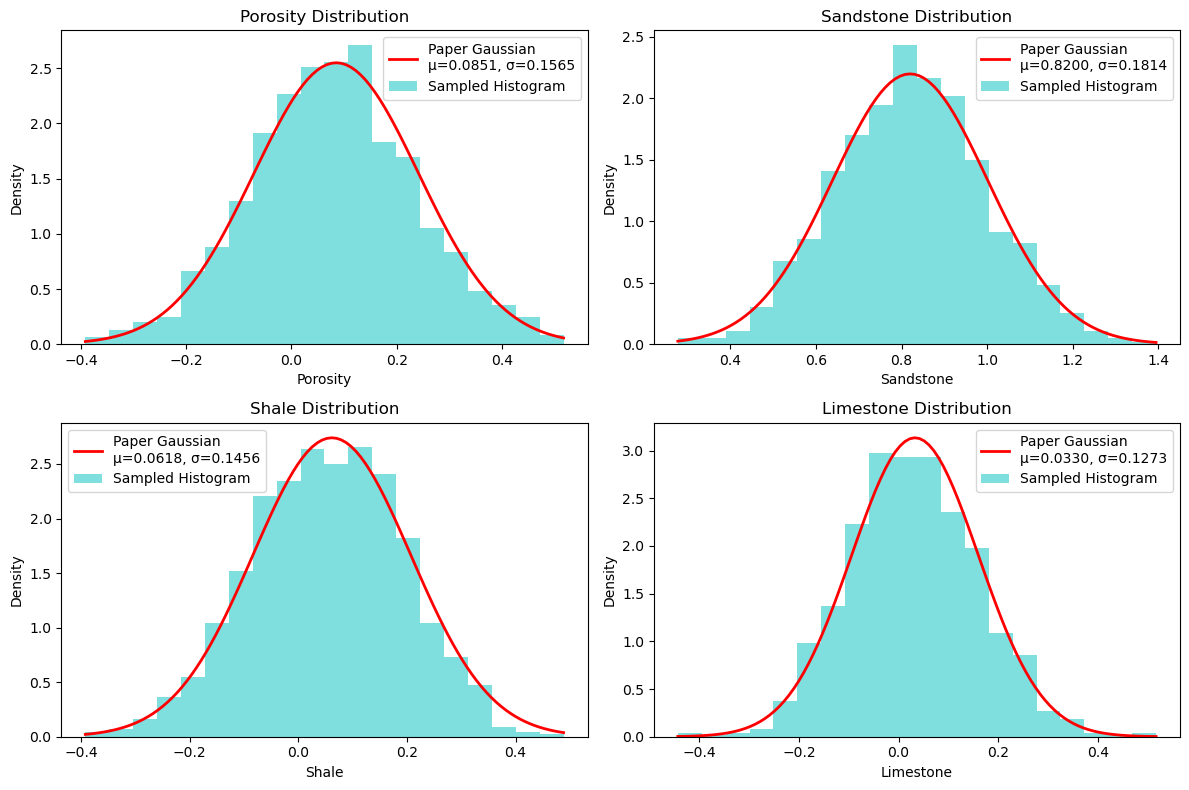

In [ ]:

from scipy.stats import norm

# --- Parameters from Table 2 of the paper: [porosity, sandstone, shale, limestone]
core_means = np.array([0.0851, 0.8200, 0.0618, 0.0330])
core_vars = np.array([0.0245, 0.0329, 0.0212, 0.0162])
core_stds = np.sqrt(core_vars)

# --- Parameter names
param_names = ["Porosity", "Sandstone", "Shale", "Limestone"]

# --- Generate synthetic data
np.random.seed(0)  # For reproducibility
synthetic_core = {}
for i, param in enumerate(param_names):
    synthetic_core[param] = np.random.normal(core_means[i], core_stds[i], 1000)

# --- Plot histograms with Gaussian fits using original paper values
plt.figure(figsize=(12, 8))
for i, param in enumerate(param_names):
    plt.subplot(2, 2, i+1)
    data = synthetic_core[param]

    # Histogram of sampled data
    plt.hist(data, bins=20, density=True, alpha=0.5, color='c', label="Sampled Histogram")

    # Gaussian fit using original mean and std from paper
    mu_orig = core_means[i]
    sigma_orig = core_stds[i]
    x = np.linspace(min(data), max(data), 100)
    plt.plot(x, norm.pdf(x, mu_orig, sigma_orig), 'r-', lw=2,
             label=f"Paper Gaussian\nμ={mu_orig:.4f}, σ={sigma_orig:.4f}")

    plt.xlabel(param)
    plt.ylabel("Density")
    plt.title(f"{param} Distribution")
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:

from scipy.optimize import minimize

# Use the calculated mean values from your filtered logs as d_obs.
# Note: The paper uses ρb, Δt and ΦN. We take the mean values and add the constraint row "1".
d_obs = np.array([density_mean, dt_mean, cnpor_mean, 1.0])

# Inversion coefficients from Table 3:
# Row order: [Density, DT, Neutron Porosity, Constraint]
G = np.array([[1.0, 2.65, 2.45, 2.71],   # for density (g/cc)
              [620, 168, 210, 156],       # for acoustic travel time (usec/ft)
              [100, -1, 25, 0],           # for neutron porosity (PU)
              [1, 1, 1, 1]])             # constraint: sum =1

# Prior model parameters for [porosity, sandstone, shale, limestone] from Table 2
m_prior = np.array([0.0851, 0.8200, 0.0618, 0.0330])
# Prior covariance matrix for the model as a diagonal matrix (variances from Table 2)
C_M = np.diag([0.0245, 0.0329, 0.0212, 0.0162])

# Covariance matrix for observed data (using Table 1 values for logs; for the constraint, use a small value)
C_D = np.diag([0.0250, 8.4559, 2.7291, 1e-6])

# Define the objective function to minimize (the misfit plus the deviation from the prior)
def objective_function(m):
    diff = G @ m - d_obs
    term_data = diff.T @ np.linalg.inv(C_D) @ diff
    term_prior = (m - m_prior).T @ np.linalg.inv(C_M) @ (m - m_prior)
    return 0.5 * (term_data + term_prior)

# Alternatively, enforce the volume constraint: m[0] + m[1] + m[2] + m[3] = 1.
cons = {'type': 'eq', 'fun': lambda m: np.sum(m) - 1}

# Run the optimization
result = minimize(objective_function, m_prior, constraints=cons, method='SLSQP')
m_estimated = result.x

print("Estimated Petrophysical Parameters:")
print(f"Porosity: {m_estimated[0]:.4f}")
print(f"Sandstone: {m_estimated[1]:.4f}")
print(f"Shale: {m_estimated[2]:.4f}")
print(f"Limestone: {m_estimated[3]:.4f}")


Estimated Petrophysical Parameters:
Porosity: -0.3154
Sandstone: 0.0268
Shale: 1.3530
Limestone: -0.0645


In [6]:
print("Number of data points in the filtered depth range:", len(depth_filtered))
print("Depth range:", depth_filtered.min(), "ft to", depth_filtered.max(), "ft\n")

Number of data points in the filtered depth range: 101
Depth range: 3600.0 ft to 3650.0 ft



In [7]:
density_mean = np.mean(density_filtered)
density_std = np.std(density_filtered)
density_var = np.var(density_filtered)
print("Bulk Density (g/cc):")
print(" Mean:", density_mean)
print(" Variance:", density_var)
print(" Std Dev:", density_std)
print(" Min:", np.min(density_filtered))
print(" Max:", np.max(density_filtered), "\n")

Bulk Density (g/cc):
 Mean: 2.5404217821782185
 Variance: 0.007200919723556511
 Std Dev: 0.08485823309235534
 Min: 2.2589
 Max: 2.739 



In [8]:
dt_mean = np.mean(dt_filtered)
dt_std = np.std(dt_filtered)
dt_var = np.var(dt_filtered)
print("Acoustic Travel Time (usec/ft):")
print(" Mean:", dt_mean)
print(" Variance:", dt_var)
print(" Std Dev:", dt_std)
print(" Min:", np.min(dt_filtered))
print(" Max:", np.max(dt_filtered), "\n")

Acoustic Travel Time (usec/ft):
 Mean: 73.25030594059406
 Variance: 254.61666655085574
 Std Dev: 15.956712272609785
 Min: 55.8252
 Max: 103.8489 



In [9]:
cnpor_mean = np.mean(cnpor_filtered)
cnpor_std = np.std(cnpor_filtered)
cnpor_var = np.var(cnpor_filtered)
print("Neutron Porosity (PU):")
print(" Mean:", cnpor_mean)
print(" Variance:", cnpor_var)
print(" Std Dev:", cnpor_std)
print(" Min:", np.min(cnpor_filtered))
print(" Max:", np.max(cnpor_filtered))

Neutron Porosity (PU):
 Mean: 15.999147524752475
 Variance: 42.175899950018625
 Std Dev: 6.494297494727095
 Min: 5.7133
 Max: 28.2499


In [ ]:


# Updated prior parameters (mean values)
m_prior = np.array([0.16, 0.75, 0.08, 0.01])  # Porosity, Sandstone, Shale, Limestone

# Updated prior covariance matrix (variances)
C_M = np.diag([0.0004, 0.0009, 0.0004, 0.0001])  # Variances for each parameter

# Updated G matrix (response coefficients)
G = np.array([
    [1.0, 2.65, 2.35, 2.71],   # Density coefficients
    [620, 168, 230, 156],       # DT coefficients
    [100, -1, 30, 0],           # Neutron Porosity coefficients
    [1.0, 1.0, 1.0, 1.0]        # Constraint row
])

# Observed data vector (mean values from well-log statistics)
d_obs = np.array([2.5404217821782185, 73.25030594059406, 15.999147524752475, 1.0])

# Covariance matrix for observed data (variances from well-log statistics)
C_D = np.diag([0.007200919723556511, 254.61666655085574, 42.175899950018625, 1e-6])


In [11]:
from scipy.optimize import minimize

# Define the objective function to minimize
def objective_function(m):
    diff = G @ m - d_obs
    term_data = diff.T @ np.linalg.inv(C_D) @ diff
    term_prior = (m - m_prior).T @ np.linalg.inv(C_M) @ (m - m_prior)
    return 0.5 * (term_data + term_prior)

# Define constraint: sum of all components must equal 1
cons = {'type': 'eq', 'fun': lambda m: np.sum(m) - 1}

# Run the optimization
result = minimize(objective_function, m_prior, constraints=cons, method='SLSQP')
m_estimated = result.x

# Print estimated petrophysical parameters
print("Estimated Petrophysical Parameters:")
print(f"Porosity: {m_estimated[0]:.4f}")
print(f"Sandstone: {m_estimated[1]:.4f}")
print(f"Shale: {m_estimated[2]:.4f}")
print(f"Limestone: {m_estimated[3]:.4f}")


Estimated Petrophysical Parameters:
Porosity: 0.0858
Sandstone: 0.8055
Shale: 0.0918
Limestone: 0.0169


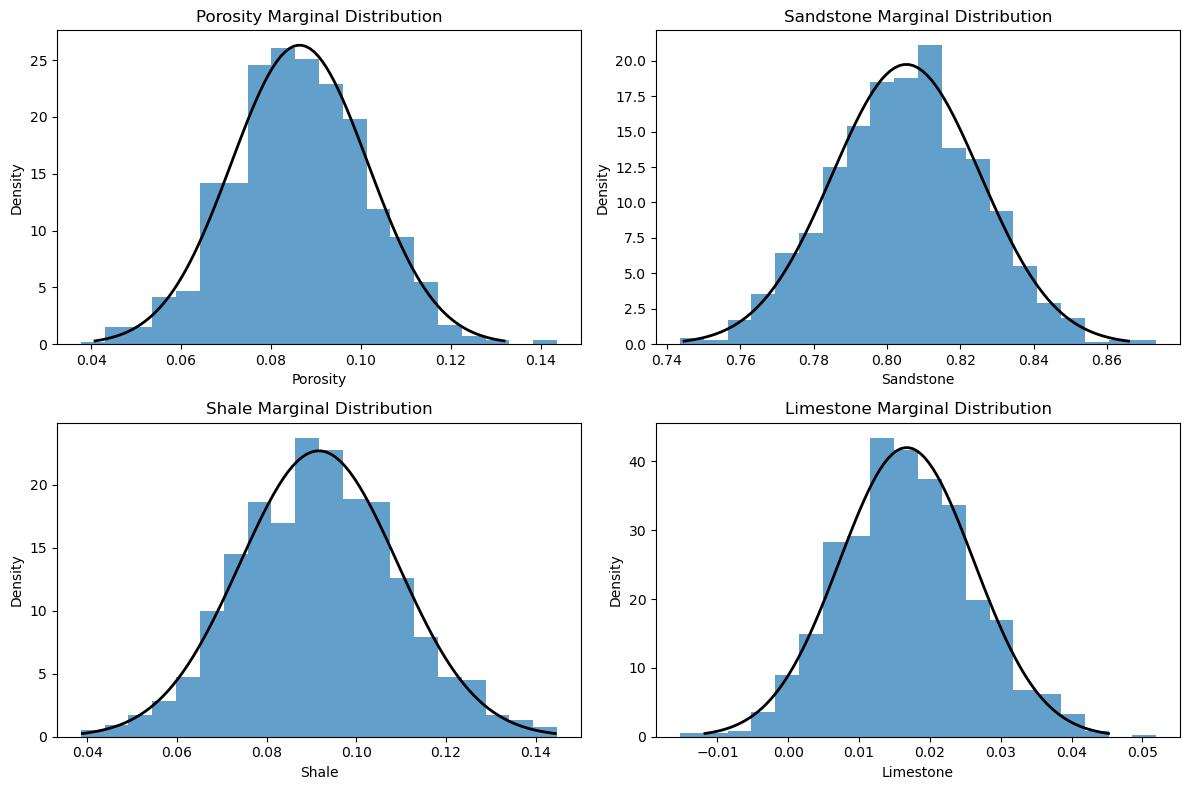

In [ ]:


# Compute posterior covariance matrix
A = G.T @ np.linalg.inv(C_D) @ G + np.linalg.inv(C_M)
Cov_post = np.linalg.inv(A)

# Generate samples from posterior distribution (e.g., 1000 samples)
num_samples = 1000
posterior_samples = np.random.multivariate_normal(m_estimated, Cov_post, size=num_samples)

# Plot marginal distributions for each parameter
param_names = ["Porosity", "Sandstone", "Shale", "Limestone"]
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist(posterior_samples[:, i], bins=20, density=True, alpha=0.7)
    sample_mean = np.mean(posterior_samples[:, i])
    sample_std = np.std(posterior_samples[:, i])
    x = np.linspace(sample_mean - 3*sample_std, sample_mean + 3*sample_std, 100)
    plt.plot(x, norm.pdf(x, sample_mean, sample_std), 'k-', lw=2)
    plt.xlabel(param_names[i])
    plt.ylabel("Density")
    plt.title(f"{param_names[i]} Marginal Distribution")
plt.tight_layout()
plt.show()


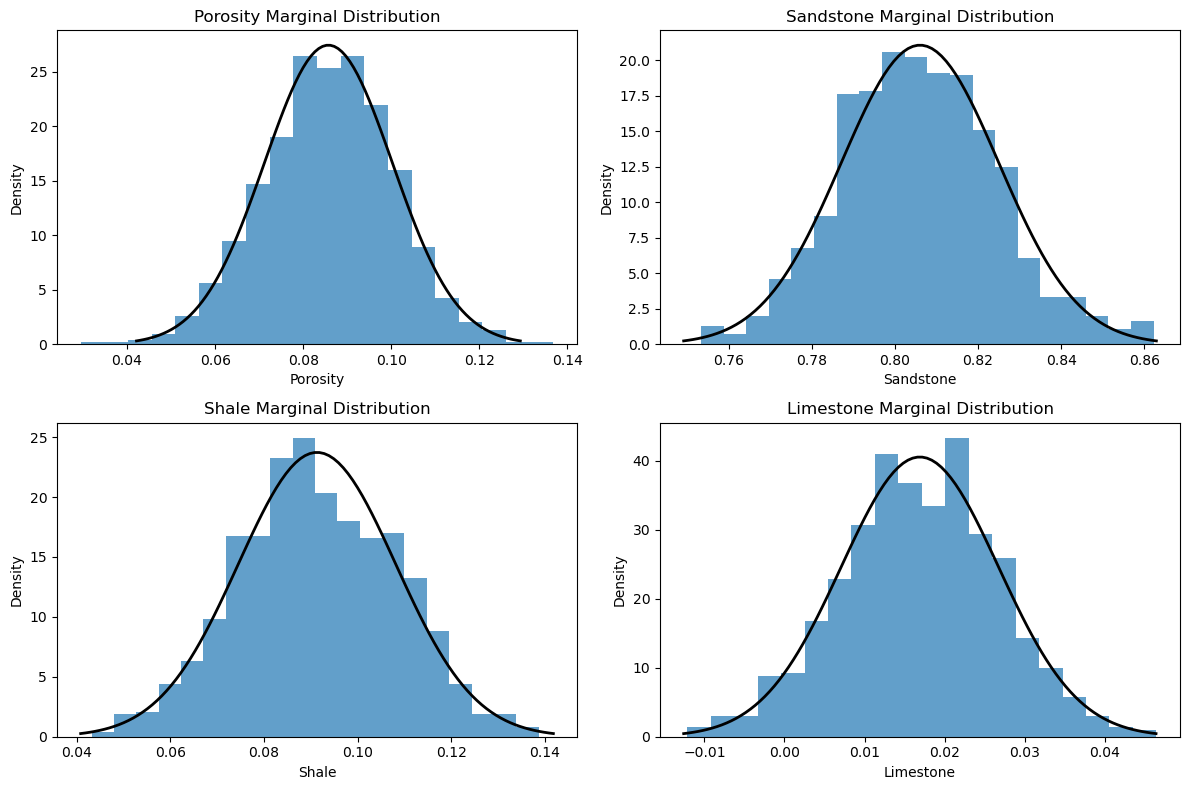

In [15]:
# Use posterior samples from Step 4
posterior_samples = np.random.multivariate_normal(m_estimated, Cov_post, size=1000)

# Plot marginal distributions
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist(posterior_samples[:, i], bins=20, density=True, alpha=0.7)
    sample_mean = np.mean(posterior_samples[:, i])
    sample_std = np.std(posterior_samples[:, i])
    x = np.linspace(sample_mean - 3*sample_std, sample_mean + 3*sample_std, 100)
    plt.plot(x, norm.pdf(x, sample_mean, sample_std), 'k-', lw=2)
    plt.title(f"{param_names[i]} Marginal Distribution")
    plt.xlabel(param_names[i])
    plt.ylabel("Density")

plt.tight_layout()
plt.show()


In [17]:
# Initialize arrays to store results
depth_results = []
porosity_results = []
sandstone_results = []
shale_results = []
limestone_results = []

# Loop through each depth point and perform Bayesian inversion
for i in range(len(depth_filtered)):
    # Observed data vector for the current depth point
    d_obs_depth = np.array([density_filtered[i], dt_filtered[i], cnpor_filtered[i], 1.0])
    
    # Define objective function for the current depth point
    def objective_function_depth(m):
        diff = G @ m - d_obs_depth
        term_data = diff.T @ np.linalg.inv(C_D) @ diff
        term_prior = (m - m_prior).T @ np.linalg.inv(C_M) @ (m - m_prior)
        return 0.5 * (term_data + term_prior)
    
    # Perform optimization with constraints
    result_depth = minimize(objective_function_depth, m_prior, constraints=cons, method='SLSQP')
    m_estimated_depth = result_depth.x
    
    # Store results
    depth_results.append(depth_filtered[i])
    porosity_results.append(m_estimated_depth[0])
    sandstone_results.append(m_estimated_depth[1])
    shale_results.append(m_estimated_depth[2])
    limestone_results.append(m_estimated_depth[3])


In [ ]:

# Extract relevant logs
depth = las["DEPT"]  # Depth in ft
density = las["RHOB"]  # Bulk Density (g/cc)
dt = las["DT"]  # Acoustic Travel Time (usec/ft)
cnpor = las["CNPOR"]  # Neutron Porosity (PU)
gr = las["GR"]  # Gamma Ray (GAPI)

# Remove NaN values
valid_idx = ~np.isnan(density) & ~np.isnan(dt) & ~np.isnan(cnpor) & ~np.isnan(gr)
depth, density, dt, cnpor, gr = depth[valid_idx], density[valid_idx], dt[valid_idx], cnpor[valid_idx], gr[valid_idx]

# Filter data for the depth range 3600 - 3650 ft
depth_mask = (depth >= 3600) & (depth <= 3650)
depth_filtered = depth[depth_mask]
density_filtered = density[depth_mask]
dt_filtered = dt[depth_mask]
cnpor_filtered = cnpor[depth_mask]
gr_filtered = gr[depth_mask]

# Calculate statistical summaries
print("STATISTICAL SUMMARY (3600-3650 ft)")
print("---------------------------------")
print("Gamma Ray (GAPI):")
print(f"  Mean: {np.mean(gr_filtered):.2f}")
print(f"  Std Dev: {np.std(gr_filtered):.2f}")
print(f"  Min: {np.min(gr_filtered):.2f}")
print(f"  Max: {np.max(gr_filtered):.2f}")

print("\nBulk Density (g/cc):")
print(f"  Mean: {np.mean(density_filtered):.4f}")
print(f"  Std Dev: {np.std(density_filtered):.4f}")
print(f"  Min: {np.min(density_filtered):.4f}")
print(f"  Max: {np.max(density_filtered):.4f}")

print("\nAcoustic Travel Time (usec/ft):")
print(f"  Mean: {np.mean(dt_filtered):.2f}")
print(f"  Std Dev: {np.std(dt_filtered):.2f}")
print(f"  Min: {np.min(dt_filtered):.2f}")
print(f"  Max: {np.max(dt_filtered):.2f}")

print("\nNeutron Porosity (PU):")
print(f"  Mean: {np.mean(cnpor_filtered):.2f}")
print(f"  Std Dev: {np.std(cnpor_filtered):.2f}")
print(f"  Min: {np.min(cnpor_filtered):.2f}")
print(f"  Max: {np.max(cnpor_filtered):.2f}")

# Calculate lithology indicators
print("\nLITHOLOGY INDICATORS")
print("---------------------------------")
# Calculate neutron-density separation (useful for lithology identification)
nd_separation = cnpor_filtered - (density_filtered - 1.0) * 100 / 1.7
print(f"Neutron-Density Separation (average): {np.mean(nd_separation):.2f}")

# GR categories (< 60 API: clean sand/carbonate, 60-90 API: shaly sand, > 90 API: shale)
clean_percent = 100 * np.sum(gr_filtered < 60) / len(gr_filtered)
shaly_sand_percent = 100 * np.sum((gr_filtered >= 60) & (gr_filtered <= 90)) / len(gr_filtered)
shale_percent = 100 * np.sum(gr_filtered > 90) / len(gr_filtered)

print(f"Clean (GR < 60 API): {clean_percent:.1f}%")
print(f"Shaly Sand (60 <= GR <= 90 API): {shaly_sand_percent:.1f}%")
print(f"Shale (GR > 90 API): {shale_percent:.1f}%")

# Mean of density, DT, and neutron in high GR (shale) zones
shale_mask = gr_filtered > 90
if np.any(shale_mask):
    print("\nShale Properties (GR > 90 API):")
    print(f"  Mean Density: {np.mean(density_filtered[shale_mask]):.4f} g/cc")
    print(f"  Mean DT: {np.mean(dt_filtered[shale_mask]):.2f} usec/ft")
    print(f"  Mean Neutron: {np.mean(cnpor_filtered[shale_mask]):.2f} PU")

# Mean of density, DT, and neutron in low GR (sand) zones
sand_mask = gr_filtered < 60
if np.any(sand_mask):
    print("\nClean Sand/Carbonate Properties (GR < 60 API):")
    print(f"  Mean Density: {np.mean(density_filtered[sand_mask]):.4f} g/cc")
    print(f"  Mean DT: {np.mean(dt_filtered[sand_mask]):.2f} usec/ft")
    print(f"  Mean Neutron: {np.mean(cnpor_filtered[sand_mask]):.2f} PU")


STATISTICAL SUMMARY (3600-3650 ft)
---------------------------------
Gamma Ray (GAPI):
  Mean: 78.08
  Std Dev: 54.34
  Min: 25.96
  Max: 289.37

Bulk Density (g/cc):
  Mean: 2.5404
  Std Dev: 0.0849
  Min: 2.2589
  Max: 2.7390

Acoustic Travel Time (usec/ft):
  Mean: 73.25
  Std Dev: 15.96
  Min: 55.83
  Max: 103.85

Neutron Porosity (PU):
  Mean: 16.00
  Std Dev: 6.49
  Min: 5.71
  Max: 28.25

LITHOLOGY INDICATORS
---------------------------------
Neutron-Density Separation (average): -74.61
Clean (GR < 60 API): 48.5%
Shaly Sand (60 <= GR <= 90 API): 14.9%
Shale (GR > 90 API): 36.6%

Shale Properties (GR > 90 API):
  Mean Density: 2.5105 g/cc
  Mean DT: 89.40 usec/ft
  Mean Neutron: 22.36 PU

Clean Sand/Carbonate Properties (GR < 60 API):
  Mean Density: 2.5578 g/cc
  Mean DT: 59.03 usec/ft
  Mean Neutron: 10.52 PU


In [ ]:


# 1. Define prior model parameters from Table 2 in the paper
m_prior = np.array([0.0851, 0.8200, 0.0618, 0.0330])  # Porosity, Sandstone, Shale, Limestone

# 2. Define prior covariance matrix from Table 2 variances
C_M = np.diag([0.0245, 0.0329, 0.0212, 0.0162])  # Diagonal covariance matrix for model parameters

# 3. Define coefficient matrix (G) from Table 3
G = np.array([
    [1.0, 2.65, 2.45, 2.71],    # Density coefficients (g/cc)
    [620, 168, 210, 156],       # Acoustic travel time coefficients (us/m)
    [100, -1, 25, 0],          # Neutron porosity coefficients (%)
    [1.0, 1.0, 1.0, 1.0]        # Volume constraint (sum = 1)
])

# 4. Compute data covariance matrix from your filtered data
density_var = np.var(density_filtered)
dt_var = np.var(dt_filtered)
cnpor_var = np.var(cnpor_filtered)
C_D = np.diag([density_var, dt_var, cnpor_var, 1e-6])  # Small value for constraint equation

# Print the setup parameters to verify
print("Prior model parameters (m_prior):", m_prior)
print("Model covariance matrix (C_M):", np.diag(C_M))
print("Data covariance matrix (C_D):", np.diag(C_D))


Prior model parameters (m_prior): [0.0851 0.82   0.0618 0.033 ]
Model covariance matrix (C_M): [0.0245 0.0329 0.0212 0.0162]
Data covariance matrix (C_D): [7.20091972e-03 2.54616667e+02 4.21759000e+01 1.00000000e-06]


In [ ]:


# Prior model parameters from Table 2 in the paper
m_prior = np.array([0.0851, 0.8200, 0.0618, 0.0330])  # Porosity, Sandstone, Shale, Limestone

# Model covariance matrix from Table 2 variances
C_M = np.diag([0.0245, 0.0329, 0.0212, 0.0162])

# Coefficient matrix (G) from Table 3
G = np.array([
    [1.0, 2.65, 2.45, 2.71],    # Density coefficients (g/cc)
    [620, 168, 210, 156],       # Acoustic travel time coefficients (us/ft)
    [100, -1, 25, 0],          # Neutron porosity coefficients (%)
    [1.0, 1.0, 1.0, 1.0]        # Volume constraint (sum = 1)
])

# Observed data vector (mean values from your filtered well-log data)
d_obs = np.array([2.5404, 73.25, 16.00, 1.0])  # Density, DT, Neutron Porosity, Constraint

# Data covariance matrix from variance of filtered data
C_D = np.diag([7.20091972e-03, 2.54616667e+02, 4.21759000e+01, 1.00000000e-06])

# Define the misfit function for Bayesian inversion
def misfit_function(m):
    # Data misfit term
    data_residual = d_obs - G @ m
    data_misfit = data_residual.T @ np.linalg.inv(C_D) @ data_residual
    
    # Prior misfit term
    prior_residual = m - m_prior
    prior_misfit = prior_residual.T @ np.linalg.inv(C_M) @ prior_residual
    
    # Total misfit
    return 0.5 * (data_misfit + prior_misfit)

# Define constraint: sum of all components must equal 1
constraint = {'type': 'eq', 'fun': lambda m: np.sum(m) - 1}

# Perform Bayesian inversion using optimization
result = minimize(misfit_function, m_prior, constraints=constraint, method='SLSQP')
m_posterior = result.x

# Print the posterior model parameters
print("Posterior Model Parameters (m_posterior):")
print(f"Porosity: {m_posterior[0]:.4f}")
print(f"Sandstone Volume: {m_posterior[1]:.4f}")
print(f"Shale Volume: {m_posterior[2]:.4f}")
print(f"Limestone Volume: {m_posterior[3]:.4f}")
print(f"Sum of volumes: {np.sum(m_posterior):.4f}")

# Compute the posterior covariance matrix (for uncertainty analysis)
hessian = np.linalg.inv(G.T @ np.linalg.inv(C_D) @ G + np.linalg.inv(C_M))
print("\nPosterior Uncertainties (standard deviations):")
print(f"Porosity: ±{np.sqrt(hessian[0,0]):.4f}")
print(f"Sandstone Volume: ±{np.sqrt(hessian[1,1]):.4f}")
print(f"Shale Volume: ±{np.sqrt(hessian[2,2]):.4f}")
print(f"Limestone Volume: ±{np.sqrt(hessian[3,3]):.4f}")


Posterior Model Parameters (m_posterior):
Porosity: -0.0968
Sandstone Volume: 0.8061
Shale Volume: 0.2408
Limestone Volume: 0.0499
Sum of volumes: 1.0000

Posterior Uncertainties (standard deviations):
Porosity: ±0.0312
Sandstone Volume: ±0.1268
Shale Volume: ±0.1218
Limestone Volume: ±0.1097


In [ ]:


# Prior model parameters from Table 2 in the paper
m_prior = np.array([0.0851, 0.8200, 0.0618, 0.0330])  # Porosity, Sandstone, Shale, Limestone

# Model covariance matrix from Table 2 variances
C_M = np.diag([0.0245, 0.0329, 0.0212, 0.0162])

# Unit conversion factor (feet to meters)
ft_to_m = 3.28084

# Coefficient matrix (G) with adjusted acoustic travel time coefficients
# Converting the acoustic travel time coefficients from us/m to usec/ft
G = np.array([
    [1.0, 2.65, 2.45, 2.71],                            # Density coefficients (g/cc)
    [620/ft_to_m, 168/ft_to_m, 210/ft_to_m, 156/ft_to_m], # Acoustic travel time (usec/ft)
    [100, -1, 25, 0],                                   # Neutron porosity coefficients (%)
    [1.0, 1.0, 1.0, 1.0]                               # Volume constraint (sum = 1)
])

# Observed data vector (mean values from filtered well-log data)
d_obs = np.array([2.5404, 73.25, 16.00, 1.0])  # Density, DT, Neutron Porosity, Constraint

# Data covariance matrix from variance of filtered data
density_var = 7.20091972e-03
dt_var = 2.54616667e+02
cnpor_var = 4.21759000e+01
C_D = np.diag([density_var, dt_var, cnpor_var, 1e-6])

# Define the misfit function for Bayesian inversion
def misfit_function(m):
    # Data misfit term
    data_residual = d_obs - G @ m
    data_misfit = data_residual.T @ np.linalg.inv(C_D) @ data_residual
    
    # Prior misfit term
    prior_residual = m - m_prior
    prior_misfit = prior_residual.T @ np.linalg.inv(C_M) @ prior_residual
    
    # Total misfit
    return 0.5 * (data_misfit + prior_misfit)

# Define constraint: sum of all components must equal 1
constraint = {'type': 'eq', 'fun': lambda m: np.sum(m) - 1}

# Add bounds to ensure physically realistic values (0 to 1 for all parameters)
bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]

# Try different initial guesses to avoid getting stuck at boundary constraints
initial_guess = np.array([0.1, 0.7, 0.1, 0.1])

# Perform Bayesian inversion using optimization
result = minimize(misfit_function, initial_guess, constraints=constraint, 
                  bounds=bounds, method='SLSQP')
m_posterior = result.x

# Print the posterior model parameters
print("Posterior Model Parameters (m_posterior):")
print(f"Porosity: {m_posterior[0]:.4f}")
print(f"Sandstone Volume: {m_posterior[1]:.4f}")
print(f"Shale Volume: {m_posterior[2]:.4f}")
print(f"Limestone Volume: {m_posterior[3]:.4f}")
print(f"Sum of volumes: {np.sum(m_posterior):.4f}")

# Compute the posterior covariance matrix (for uncertainty analysis)
hessian = np.linalg.inv(G.T @ np.linalg.inv(C_D) @ G + np.linalg.inv(C_M))
print("\nPosterior Uncertainties (standard deviations):")
print(f"Porosity: ±{np.sqrt(hessian[0,0]):.4f}")
print(f"Sandstone Volume: ±{np.sqrt(hessian[1,1]):.4f}")
print(f"Shale Volume: ±{np.sqrt(hessian[2,2]):.4f}")
print(f"Limestone Volume: ±{np.sqrt(hessian[3,3]):.4f}")


Posterior Model Parameters (m_posterior):
Porosity: 0.0973
Sandstone Volume: 0.7934
Shale Volume: 0.0805
Limestone Volume: 0.0288
Sum of volumes: 1.0000

Posterior Uncertainties (standard deviations):
Porosity: ±0.0428
Sandstone Volume: ±0.1268
Shale Volume: ±0.1241
Limestone Volume: ±0.1098


Starting inversion for all depth points...
Processing depth point 1/101
Processing depth point 11/101
Processing depth point 21/101
Processing depth point 31/101
Processing depth point 41/101
Processing depth point 51/101
Processing depth point 61/101
Processing depth point 71/101
Processing depth point 81/101
Processing depth point 91/101
Processing depth point 101/101


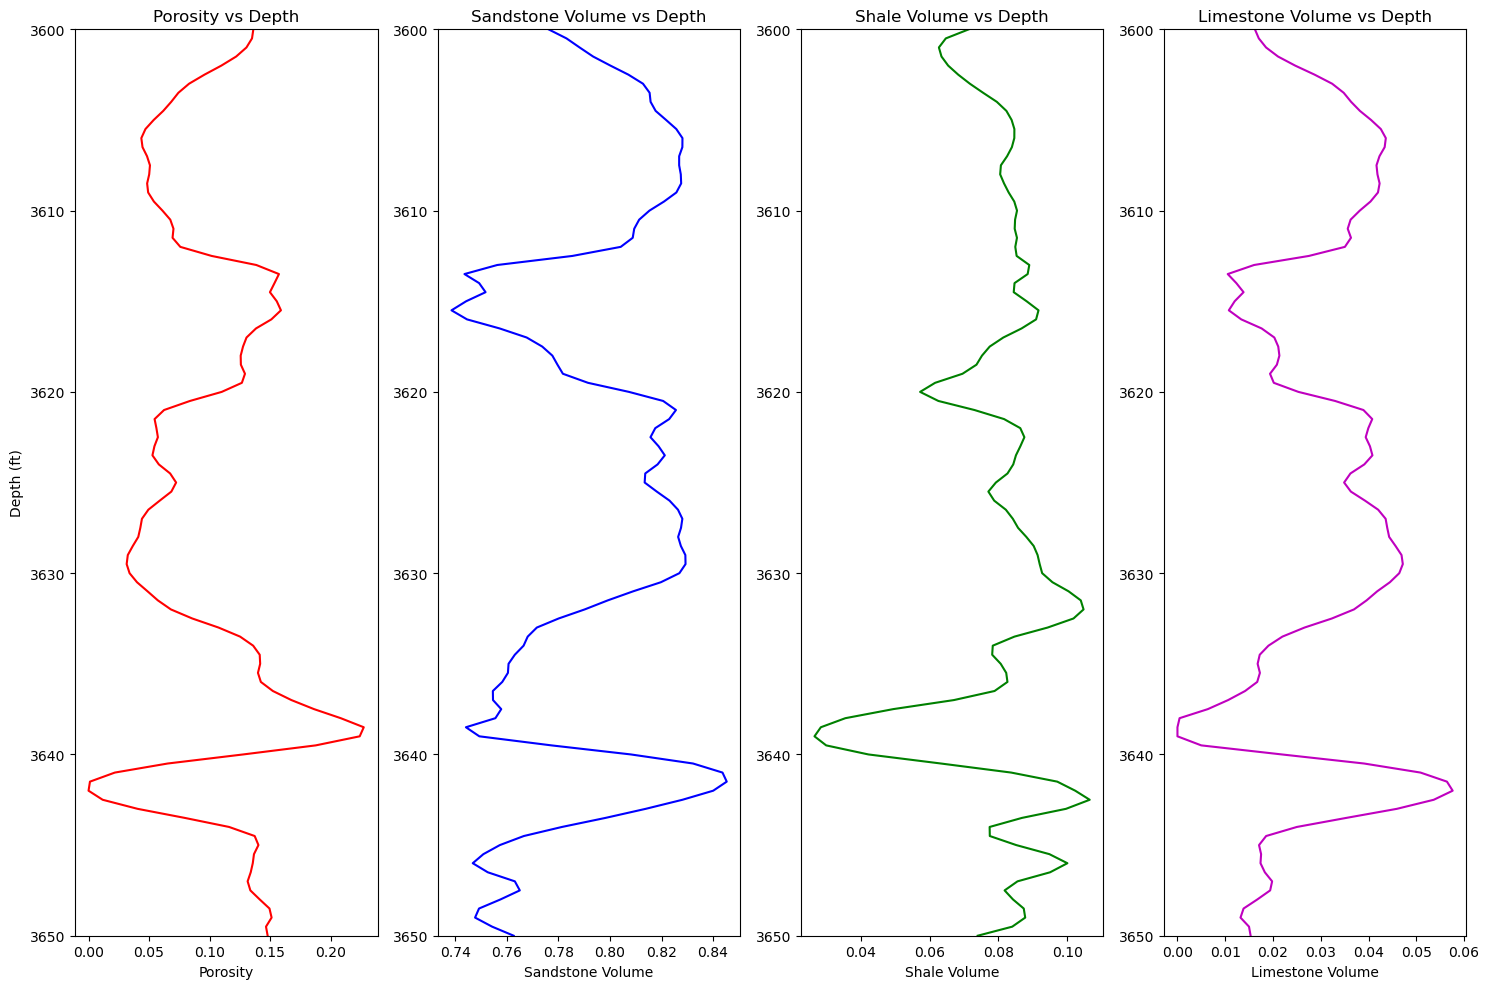


Statistical Summary of Inversion Results:
Porosity: Mean = 0.0973, Std = 0.0503
Sandstone: Mean = 0.7933, Std = 0.0309
Shale: Mean = 0.0804, Std = 0.0150
Limestone: Mean = 0.0290, Std = 0.0136


In [ ]:

# Load LAS file and extract logs
las = lasio.read("1054146917.las")
depth = las["DEPT"]
density = las["RHOB"]
dt = las["DT"]
cnpor = las["CNPOR"]

# Filter data for depth range 3600-3650 ft
valid_idx = ~np.isnan(density) & ~np.isnan(dt) & ~np.isnan(cnpor)
depth, density, dt, cnpor = depth[valid_idx], density[valid_idx], dt[valid_idx], cnpor[valid_idx]
depth_mask = (depth >= 3600) & (depth <= 3650)
depth_filtered = depth[depth_mask]
density_filtered = density[depth_mask]
dt_filtered = dt[depth_mask]
cnpor_filtered = cnpor[depth_mask]

# Define prior model parameters from Table 2 in the paper
m_prior = np.array([0.0851, 0.8200, 0.0618, 0.0330])  # Porosity, Sandstone, Shale, Limestone

# Define prior covariance matrix from Table 2 variances
C_M = np.diag([0.0245, 0.0329, 0.0212, 0.0162])

# Unit conversion factor (feet to meters)
ft_to_m = 3.28084

# Coefficient matrix (G) with adjusted acoustic travel time coefficients
G = np.array([
    [1.0, 2.65, 2.45, 2.71],                            # Density coefficients (g/cc)
    [620/ft_to_m, 168/ft_to_m, 210/ft_to_m, 156/ft_to_m], # Acoustic travel time (usec/ft)
    [100, -1, 25, 0],                                   # Neutron porosity coefficients (%)
    [1.0, 1.0, 1.0, 1.0]                               # Volume constraint (sum = 1)
])

# Observed data vectors for all depth points
observed_data = np.column_stack((density_filtered, dt_filtered, cnpor_filtered, np.ones_like(depth_filtered)))

# Data covariance matrix from variance of filtered data
density_var = np.var(density_filtered)
dt_var = np.var(dt_filtered)
cnpor_var = np.var(cnpor_filtered)
C_D = np.diag([density_var, dt_var, cnpor_var, 1e-6])

# Define the misfit function for Bayesian inversion
def misfit_function(m, d_obs):
    # Data misfit term
    data_residual = d_obs - G @ m
    data_misfit = data_residual.T @ np.linalg.inv(C_D) @ data_residual
    
    # Prior misfit term
    prior_residual = m - m_prior
    prior_misfit = prior_residual.T @ np.linalg.inv(C_M) @ prior_residual
    
    # Total misfit
    return 0.5 * (data_misfit + prior_misfit)

# Define constraint: sum of all components must equal 1
constraint = {'type': 'eq', 'fun': lambda m: np.sum(m) - 1}

# Add bounds to ensure physically realistic values (0 to 1 for all parameters)
bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]

# Initial guess
initial_guess = np.array([0.1, 0.7, 0.1, 0.1])

# Perform Bayesian inversion for all depth points
print("Starting inversion for all depth points...")
posterior_results = []
for i, d_obs in enumerate(observed_data):
    if i % 10 == 0:  # Print progress every 10 depth points
        print(f"Processing depth point {i+1}/{len(observed_data)}")
    
    result = minimize(misfit_function, initial_guess, args=(d_obs,), 
                      constraints=constraint, bounds=bounds, method='SLSQP')
    posterior_results.append(result.x)

posterior_results = np.array(posterior_results)

# Plot the results (similar to Figure 5 in the paper)
plt.figure(figsize=(15, 10))




# Print statistical summary of inversion results
print("\nStatistical Summary of Inversion Results:")
print(f"Porosity: Mean = {np.mean(posterior_results[:, 0]):.4f}, Std = {np.std(posterior_results[:, 0]):.4f}")
print(f"Sandstone: Mean = {np.mean(posterior_results[:, 1]):.4f}, Std = {np.std(posterior_results[:, 1]):.4f}")
print(f"Shale: Mean = {np.mean(posterior_results[:, 2]):.4f}, Std = {np.std(posterior_results[:, 2]):.4f}")
print(f"Limestone: Mean = {np.mean(posterior_results[:, 3]):.4f}, Std = {np.std(posterior_results[:, 3]):.4f}")


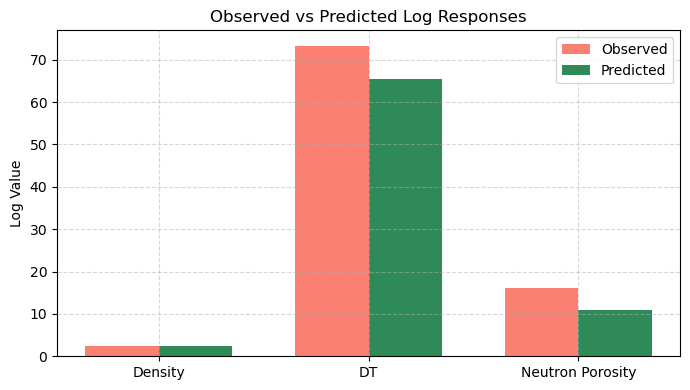

In [13]:
# Calculate predicted log responses from posterior model
d_pred = G @ m_posterior

log_names = ["Density", "DT", "Neutron Porosity"]
x = np.arange(len(log_names))
width = 0.35

plt.figure(figsize=(7, 4))
plt.bar(x - width/2, d_obs[:3], width, label="Observed", color="salmon")
plt.bar(x + width/2, d_pred[:3], width, label="Predicted", color="seagreen")
plt.xticks(x, log_names)
plt.ylabel("Log Value")
plt.title("Observed vs Predicted Log Responses")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


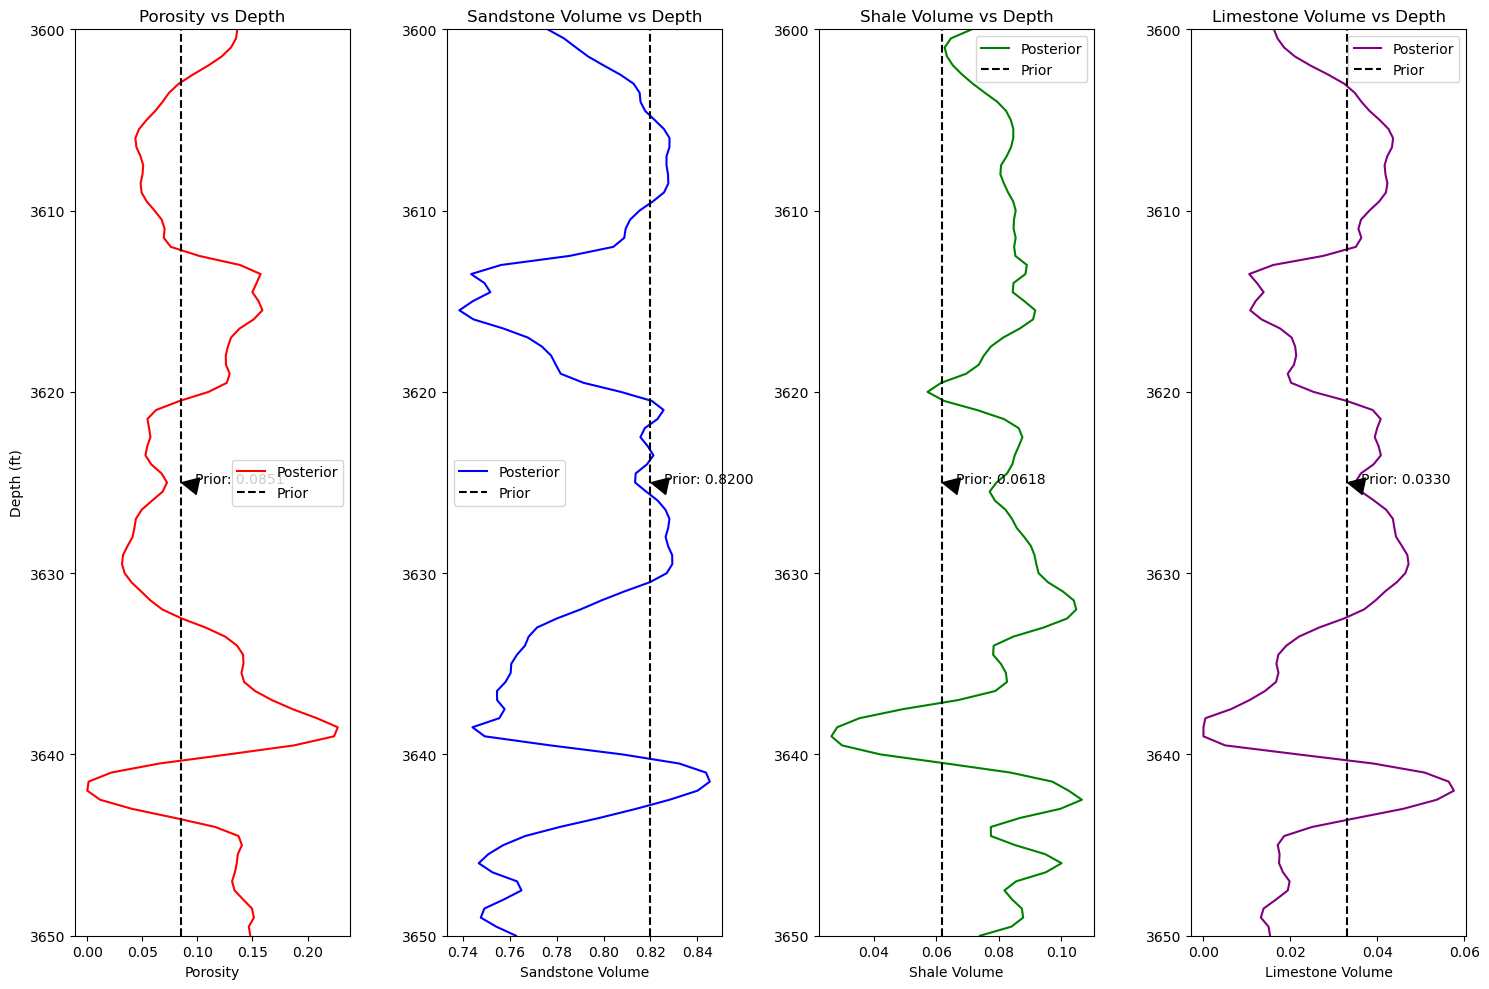

In [ ]:


# Prior model parameters from Table 2 in the paper
m_prior = np.array([0.0851, 0.8200, 0.0618, 0.0330])  # [Porosity, Sandstone, Shale, Limestone]
parameter_names = ["Porosity", "Sandstone Volume", "Shale Volume", "Limestone Volume"]
colors = ['red', 'blue', 'green', 'purple']


# Create a figure for depth profiles with m_prior comparison
plt.figure(figsize=(15, 10))

# Plot each parameter separately
for i in range(4):
    plt.subplot(1, 4, i+1)
    
    # Plot posterior values vs depth
    plt.plot(posterior_results[:, i], depth_filtered, colors[i], label='Posterior')
    
    # Plot prior value (constant across all depths)
    plt.axvline(x=m_prior[i], color='black', linestyle='--', label='Prior')
    
    plt.ylim(depth_filtered.max(), depth_filtered.min())  # Invert y-axis
    plt.xlabel(parameter_names[i])
    plt.ylabel('Depth (ft)' if i == 0 else '')
    plt.title(f'{parameter_names[i]} vs Depth')
    plt.legend()
    
    # Add text annotation showing prior value
    plt.annotate(f'Prior: {m_prior[i]:.4f}', 
                 xy=(m_prior[i], np.mean(depth_filtered)),
                 xytext=(m_prior[i] + 0.05*(plt.xlim()[1] - plt.xlim()[0]), 
                         np.mean(depth_filtered)),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

plt.tight_layout()
plt.savefig('depth_profile_comparison.png', dpi=300)
plt.show()


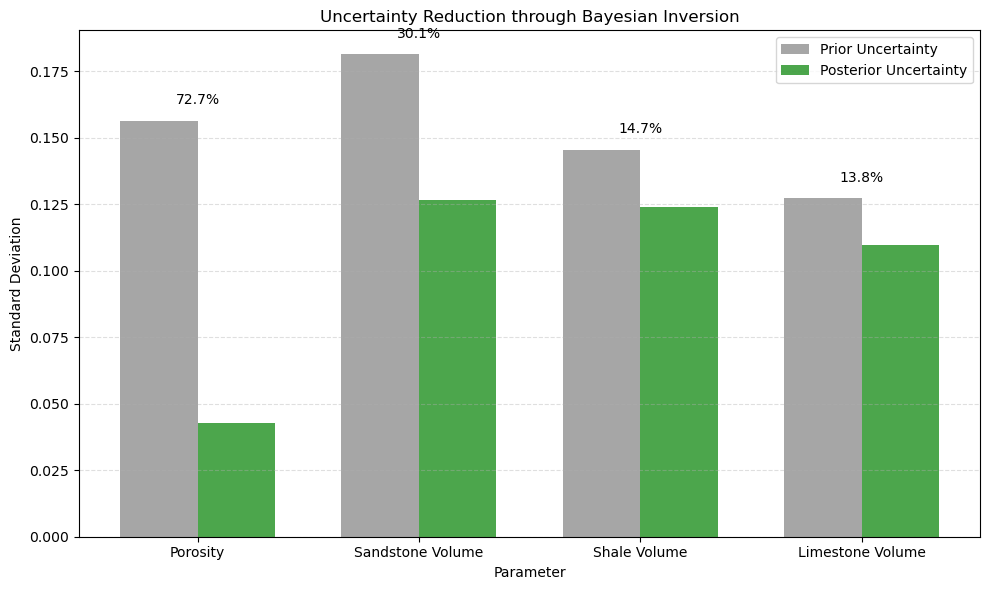

In [ ]:

prior_std = np.sqrt(np.diag(C_M))

# Create a bar chart comparing prior and posterior uncertainties
plt.figure(figsize=(10, 6))

# Set the positions for bars
x = np.arange(len(parameter_names))
width = 0.35

# Create bars
plt.bar(x - width/2, prior_std, width, label='Prior Uncertainty', alpha=0.7, color='gray')
plt.bar(x + width/2, posterior_std, width, label='Posterior Uncertainty', alpha=0.7, color='green')

# Calculate and display percentage reduction in uncertainty
for i in range(len(prior_std)):
    reduction = ((prior_std[i] - posterior_std[i]) / prior_std[i]) * 100
    plt.text(x[i], max(prior_std[i], posterior_std[i]) + 0.005, 
             f'{reduction:.1f}%', ha='center', va='bottom')

# Add labels and title
plt.xlabel('Parameter')
plt.ylabel('Standard Deviation')
plt.title('Uncertainty Reduction through Bayesian Inversion')
plt.xticks(x, parameter_names)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('uncertainty_reduction.png', dpi=300)
plt.show()


In [35]:
from scipy.stats import truncnorm

# Parameters
mu = 0.0851
sigma = 0.0245
a, b = 0, 1
a_std, b_std = (a - mu) / sigma, (b - mu) / sigma

# Create truncated normal distribution
trunc_dist = truncnorm(a_std, b_std, loc=mu, scale=sigma)

# Get 95% and 99% range (percentiles)
lower_95, upper_95 = trunc_dist.ppf(0.025), trunc_dist.ppf(0.975)


print(f"95% range: {lower_95:.4f} to {upper_95:.4f}")



95% range: 0.0372 to 0.1331


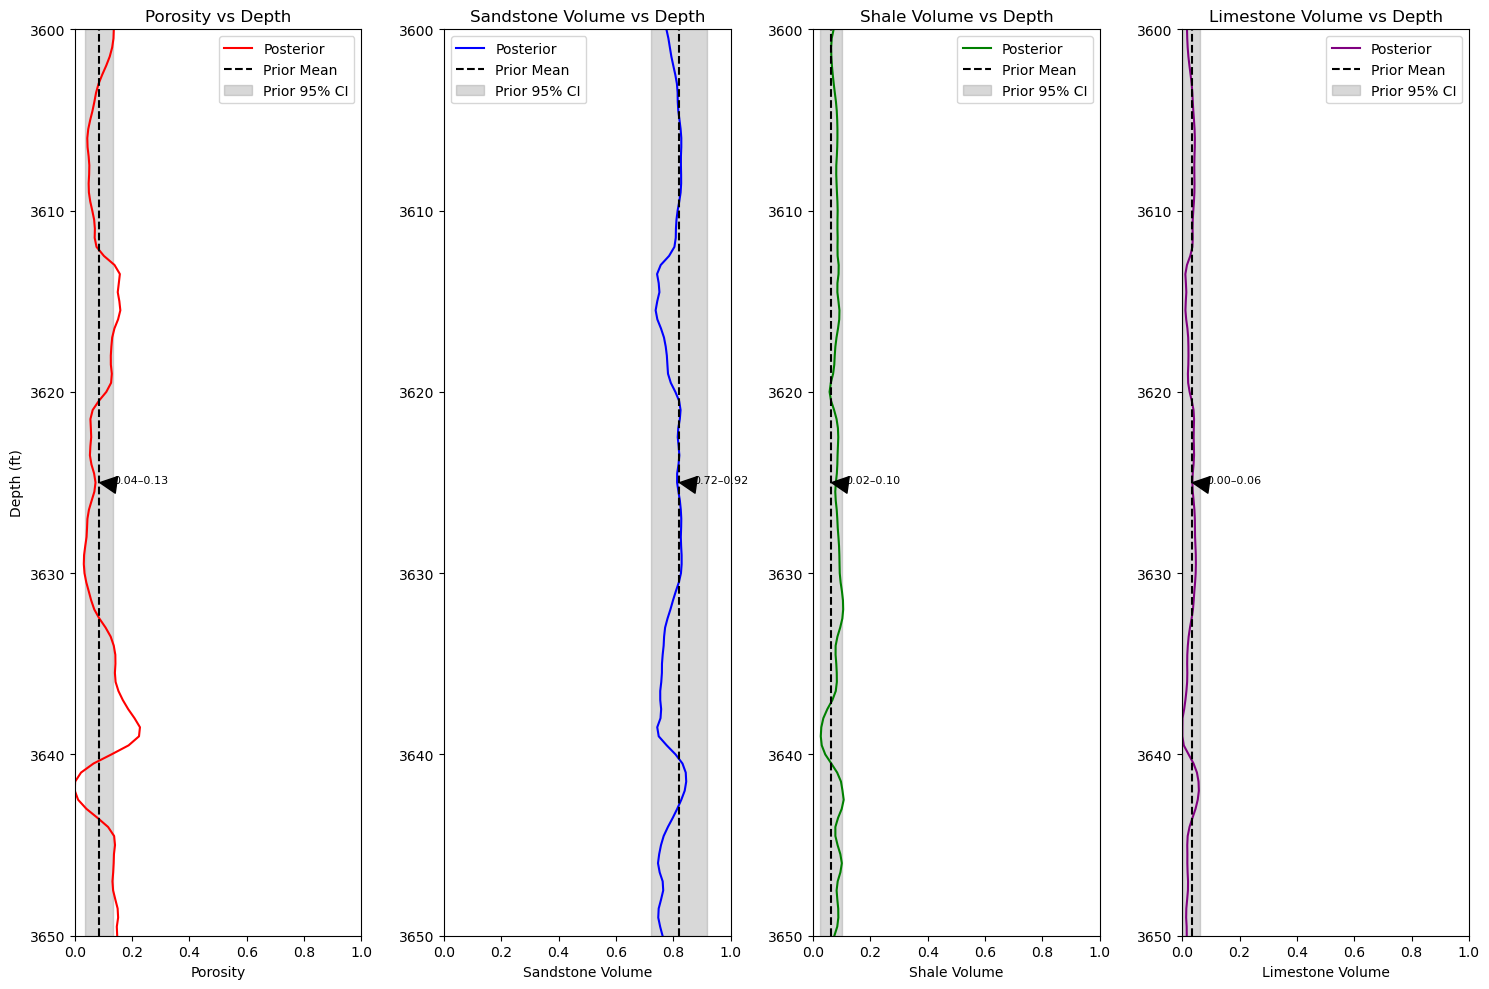

In [ ]:

# Prior model parameters and assumed standard deviations
m_prior = np.array([0.0851, 0.8200, 0.0618, 0.0330])  # mean values
std_dev = np.array([0.0245, 0.05, 0.02, 0.015])       # assumed std devs for each

# Compute 95% CI
lower_bounds = m_prior - 1.96 * std_dev
upper_bounds = m_prior + 1.96 * std_dev

parameter_names = ["Porosity", "Sandstone Volume", "Shale Volume", "Limestone Volume"]
colors = ['red', 'blue', 'green', 'purple']

plt.figure(figsize=(15, 10))

for i in range(4):
    plt.subplot(1, 4, i+1)

    # Plot posterior values
    plt.plot(posterior_results[:, i], depth_filtered, colors[i], label='Posterior')

    # Plot prior mean line
    plt.axvline(x=m_prior[i], color='black', linestyle='--', label='Prior Mean')

    # Plot 95% CI as shaded band
    plt.axvspan(lower_bounds[i], upper_bounds[i], color='gray', alpha=0.3, label='Prior 95% CI')

    # Set axis limits
    plt.xlim(0, 1)
    plt.ylim(depth_filtered.max(), depth_filtered.min())  # invert y-axis
    plt.xlabel(parameter_names[i])
    plt.ylabel('Depth (ft)' if i == 0 else '')
    plt.title(f'{parameter_names[i]} vs Depth')
    plt.legend()

    # Add annotation
    y_mid = np.mean(depth_filtered)
    plt.annotate(f'{lower_bounds[i]:.2f}–{upper_bounds[i]:.2f}', 
                 xy=(m_prior[i], y_mid),
                 xytext=(m_prior[i] + 0.05, y_mid),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                 fontsize=8)

plt.tight_layout()
plt.savefig('depth_profile_with_prior_ranges.png', dpi=300)
plt.show()


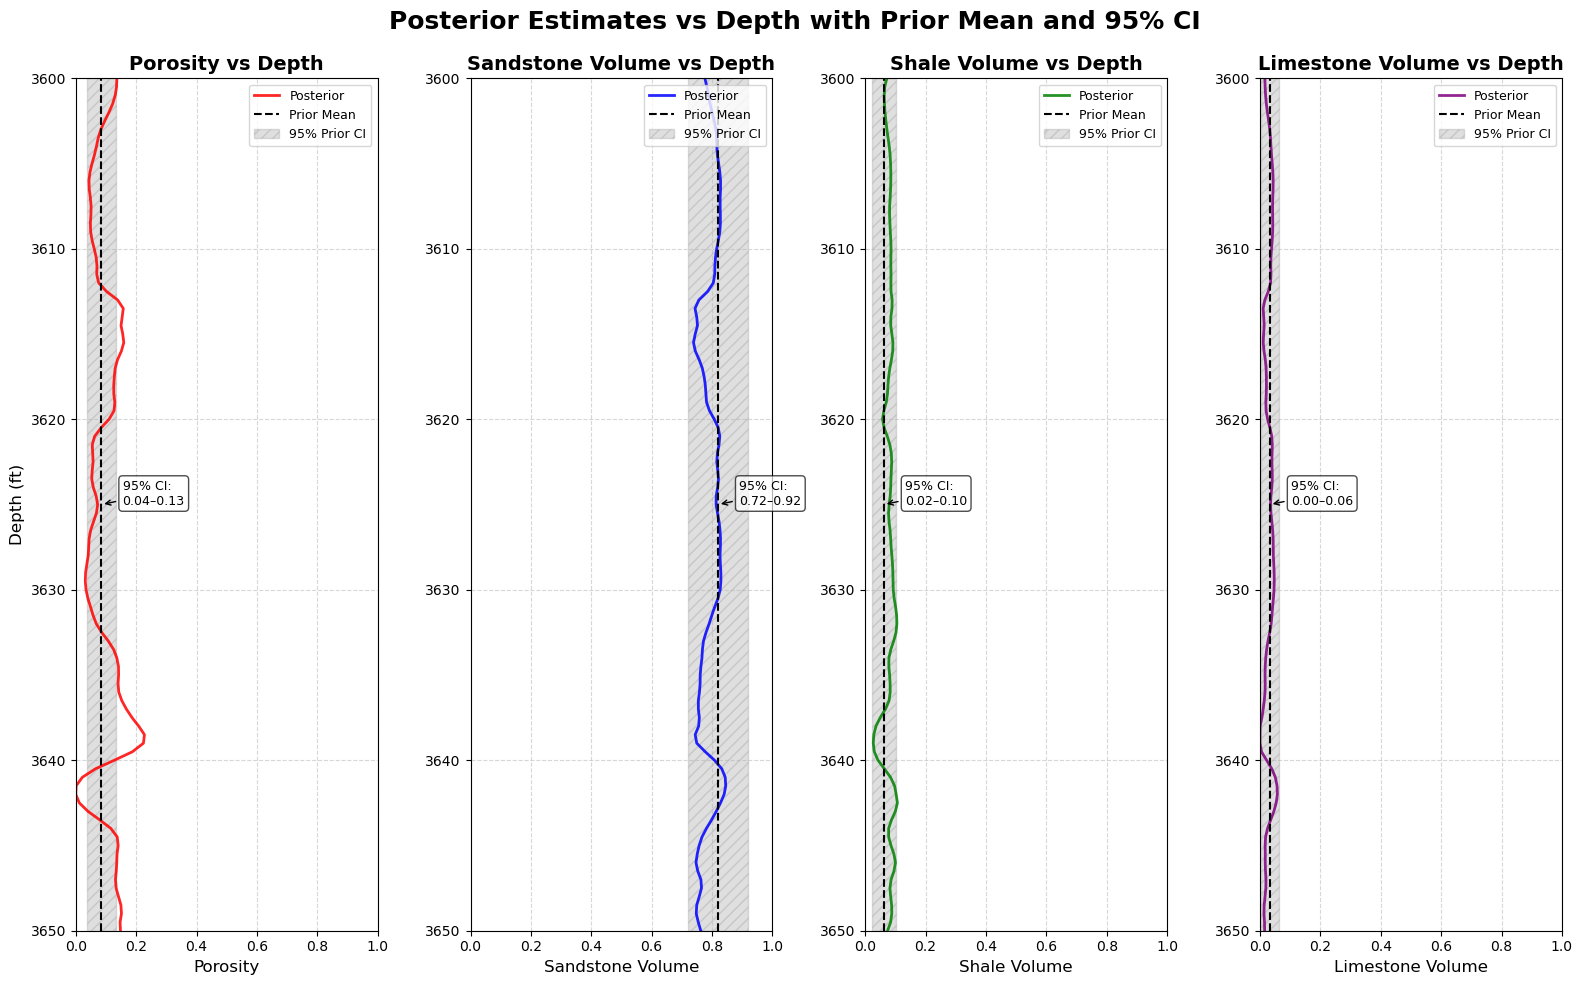

In [ ]:


# Prior model parameters and assumed standard deviations
m_prior = np.array([0.0851, 0.8200, 0.0618, 0.0330])  # mean values
std_dev = np.array([0.0245, 0.05, 0.02, 0.015])       # assumed std devs for each

# Compute 95% CI
lower_bounds = m_prior - 1.96 * std_dev
upper_bounds = m_prior + 1.96 * std_dev

parameter_names = ["Porosity", "Sandstone Volume", "Shale Volume", "Limestone Volume"]
colors = ['red', 'blue', 'green', 'purple']

plt.figure(figsize=(16, 10))
plt.suptitle("Posterior Estimates vs Depth with Prior Mean and 95% CI", fontsize=18, fontweight='bold')

for i in range(4):
    plt.subplot(1, 4, i + 1)
    
    # Plot posterior values
    plt.plot(posterior_results[:, i], depth_filtered, color=colors[i], label='Posterior', alpha=0.85, linewidth=2)

    # Plot prior mean line
    plt.axvline(x=m_prior[i], color='black', linestyle='--', label='Prior Mean')

    # Plot 95% CI as shaded band
    plt.axvspan(lower_bounds[i], upper_bounds[i], color='gray', alpha=0.25, label='95% Prior CI', hatch='///')

    # Set axis limits and labels
    plt.xlim(0, 1)
    plt.ylim(depth_filtered.max(), depth_filtered.min())  # Invert y-axis
    plt.xlabel(parameter_names[i], fontsize=12)
    if i == 0:
        plt.ylabel('Depth (ft)', fontsize=12)
    else:
        plt.ylabel('')
    plt.title(f'{parameter_names[i]} vs Depth', fontsize=14, fontweight='bold')

    # Add annotation with box and arrow
    y_mid = np.mean(depth_filtered)
    plt.annotate(f'95% CI:\n{lower_bounds[i]:.2f}–{upper_bounds[i]:.2f}',
                 xy=(m_prior[i], y_mid),
                 xytext=(m_prior[i] + 0.07, y_mid),
                 arrowprops=dict(arrowstyle="->", color='black'),
                 fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', alpha=0.7))

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(loc='upper right', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('depth_profile_with_prior_ranges_enhanced.png', dpi=300)
plt.show()


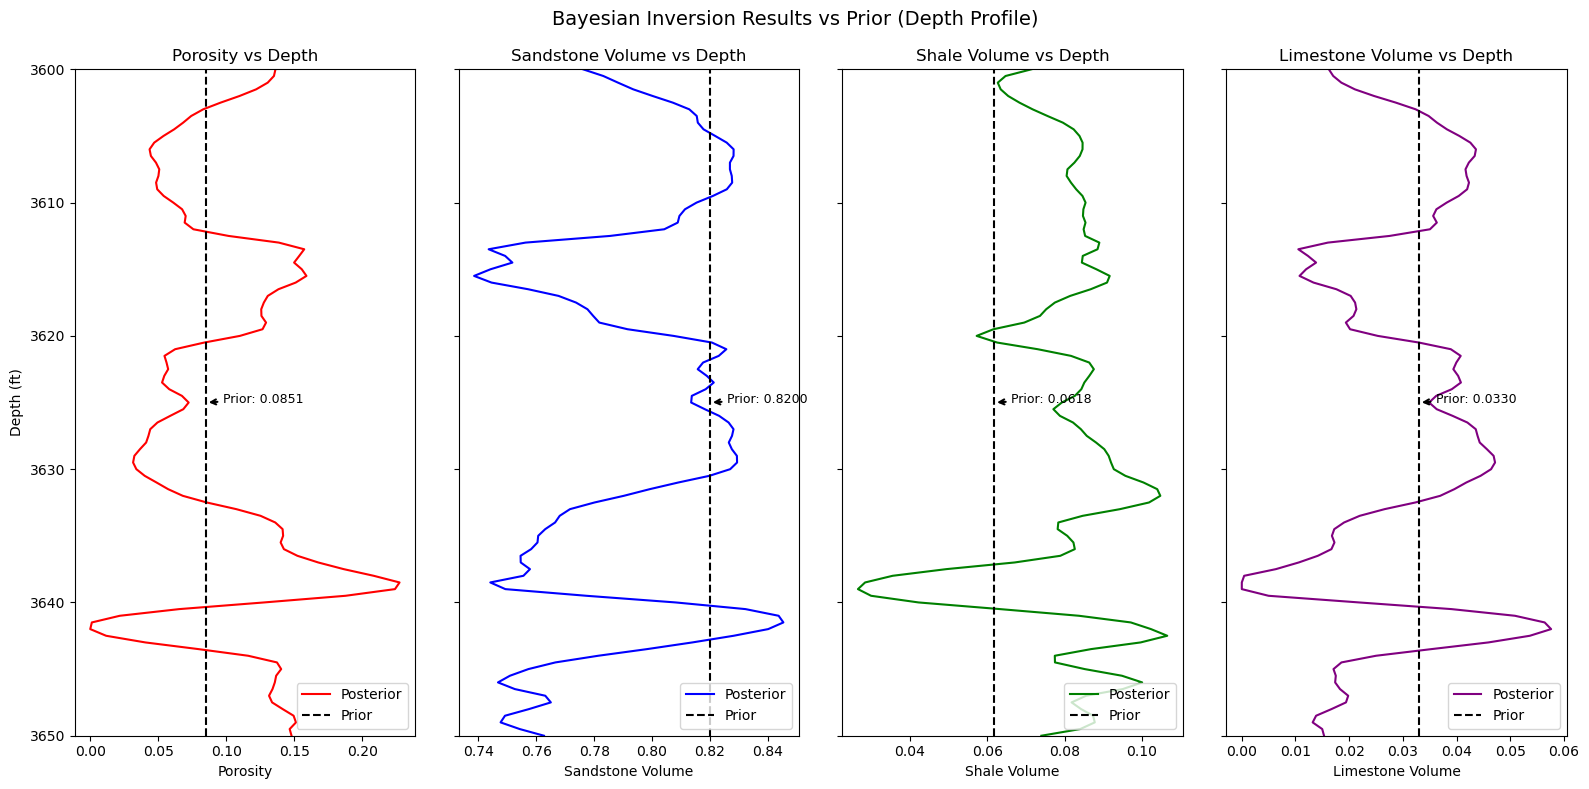

In [ ]:


# Make sure these are defined
m_prior = np.array([0.0851, 0.8200, 0.0618, 0.0330])  # Prior values from paper
parameter_names = ["Porosity", "Sandstone Volume", "Shale Volume", "Limestone Volume"]
colors = ['red', 'blue', 'green', 'purple']

# posterior_models: (n_depths x 4), depth_filtered: (n_depths)
posterior_results = np.array(posterior_models)

# Create multi-panel plot (1 row x 4 columns)
plt.figure(figsize=(16, 8))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    
    # Plot posterior result vs depth
    plt.plot(posterior_results[:, i], depth_filtered, color=colors[i], label='Posterior')
    
    # Plot prior as vertical line
    plt.axvline(x=m_prior[i], color='black', linestyle='--', label='Prior')
    
    # Invert y-axis (depth increases downward)
    plt.ylim(depth_filtered.max(), depth_filtered.min())
    plt.xlabel(parameter_names[i])
    if i == 0:
        plt.ylabel("Depth (ft)")
    else:
        plt.gca().set_yticklabels([])
    
    plt.title(f"{parameter_names[i]} vs Depth")
    plt.legend(loc='lower right')

    # Add annotation
    x_range = plt.xlim()
    y_pos = np.mean(depth_filtered)
    plt.annotate(f"Prior: {m_prior[i]:.4f}",
                 xy=(m_prior[i], y_pos),
                 xytext=(m_prior[i] + 0.05 * (x_range[1] - x_range[0]), y_pos),
                 arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
                 fontsize=9)

plt.suptitle("Bayesian Inversion Results vs Prior (Depth Profile)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("depth_profile_comparison.png", dpi=300)
plt.show()


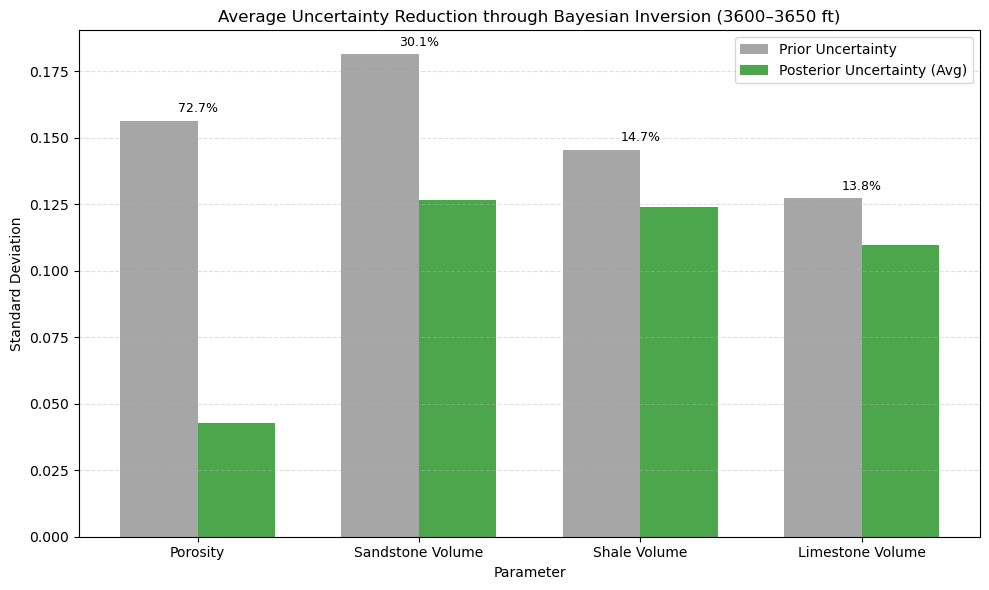

In [ ]:


# Prior uncertainties (from core data)
prior_std = np.sqrt(np.diag(C_M))

# Average posterior uncertainty across all depths
posterior_std_avg = np.mean(posterior_uncertainties, axis=0)

# Create bar chart
plt.figure(figsize=(10, 6))
x = np.arange(len(parameter_names))
width = 0.35

# Plot prior vs posterior uncertainty
plt.bar(x - width/2, prior_std, width, label='Prior Uncertainty', alpha=0.7, color='gray')
plt.bar(x + width/2, posterior_std_avg, width, label='Posterior Uncertainty (Avg)', alpha=0.7, color='green')

# Annotate percentage reduction
for i in range(len(prior_std)):
    reduction = ((prior_std[i] - posterior_std_avg[i]) / prior_std[i]) * 100
    plt.text(x[i], max(prior_std[i], posterior_std_avg[i]) + 0.002, 
             f'{reduction:.1f}%', ha='center', va='bottom', fontsize=9)

# Labels, title, and formatting
plt.xlabel('Parameter')
plt.ylabel('Standard Deviation')
plt.title('Average Uncertainty Reduction through Bayesian Inversion (3600–3650 ft)')
plt.xticks(x, parameter_names)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('uncertainty_reduction_avg.png', dpi=300)
plt.show()


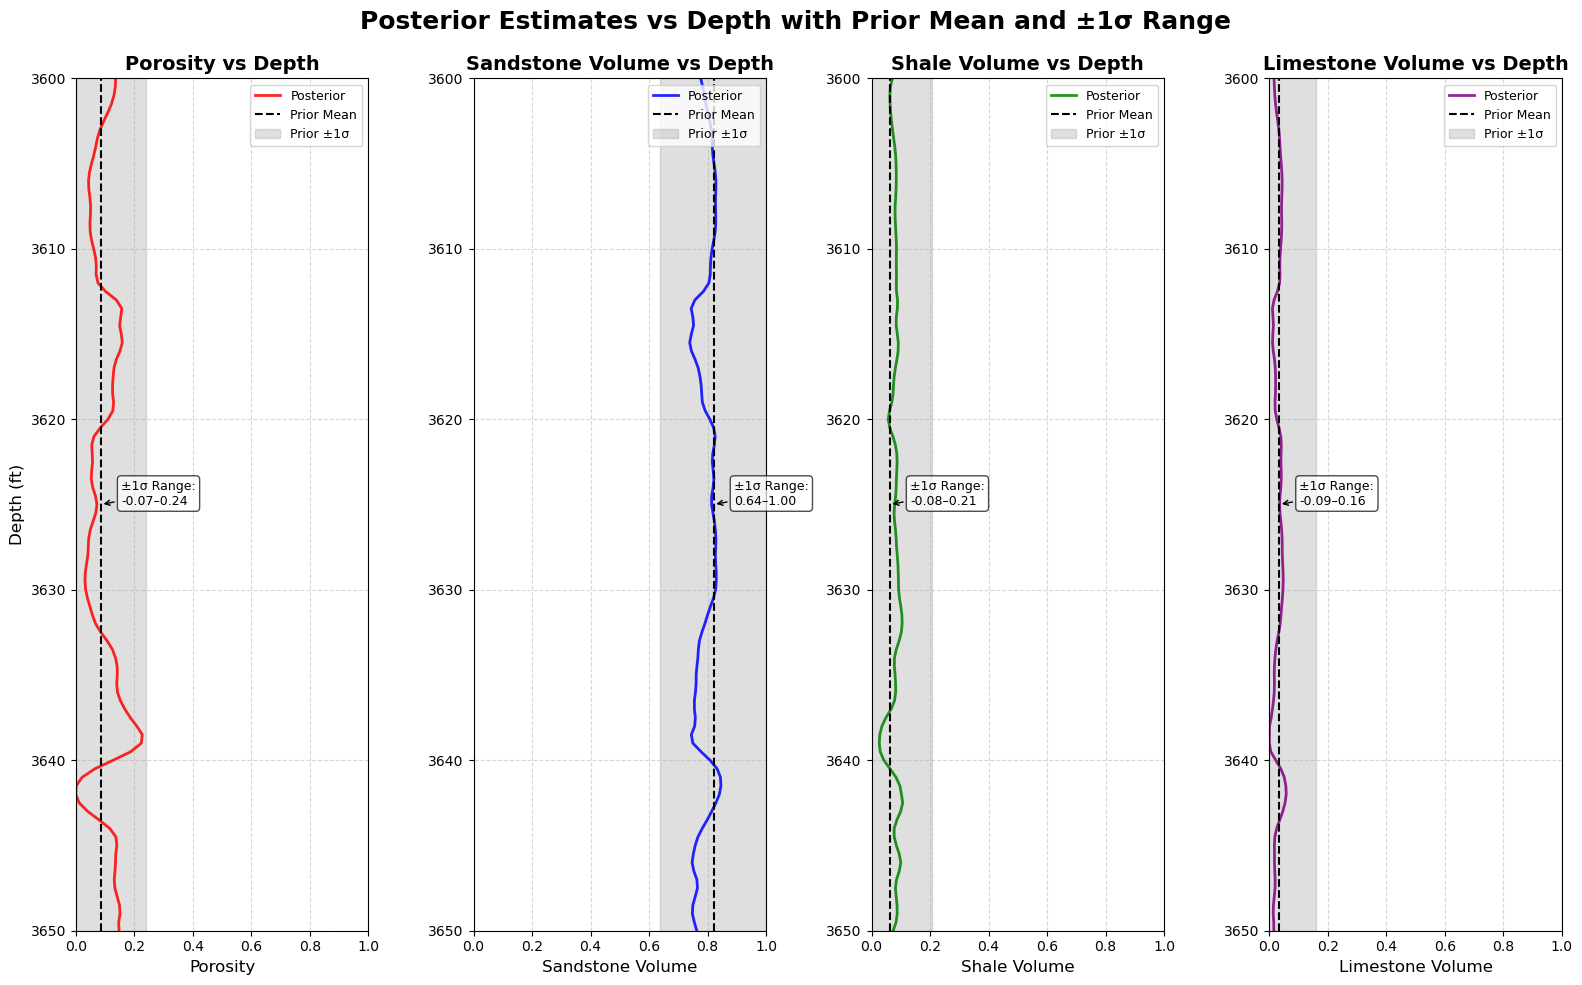

In [ ]:


# Prior model mean and variance from the paper (Table 2)
m_prior = np.array([0.0851, 0.8200, 0.0618, 0.0330])  # mean values
C_M = np.diag([0.0245, 0.0329, 0.0212, 0.0162])       # variances
std_dev = np.sqrt(np.diag(C_M))                      # standard deviations (1σ)

# Compute prior range as ±1 standard deviation
lower_bounds = m_prior - std_dev
upper_bounds = m_prior + std_dev

# Parameter labels and colors
parameter_names = ["Porosity", "Sandstone Volume", "Shale Volume", "Limestone Volume"]
colors = ['red', 'blue', 'green', 'purple']

# Start figure
plt.figure(figsize=(16, 10))
plt.suptitle("Posterior Estimates vs Depth with Prior Mean and ±1σ Range", fontsize=18, fontweight='bold')

# Loop over all 4 parameters
for i in range(4):
    plt.subplot(1, 4, i + 1)
    
    # Plot posterior values vs depth
    plt.plot(posterior_results[:, i], depth_filtered, color=colors[i], label='Posterior', alpha=0.85, linewidth=2)

    # Plot prior mean as dashed line
    plt.axvline(x=m_prior[i], color='black', linestyle='--', label='Prior Mean')

    # Plot shaded region for ±1σ prior range
    plt.axvspan(lower_bounds[i], upper_bounds[i], color='gray', alpha=0.25, label='Prior ±1σ')

    # Axis settings
    plt.xlim(0, 1)
    plt.ylim(depth_filtered.max(), depth_filtered.min())  # Invert y-axis
    plt.xlabel(parameter_names[i], fontsize=12)
    if i == 0:
        plt.ylabel('Depth (ft)', fontsize=12)
    else:
        plt.ylabel('')
    plt.title(f'{parameter_names[i]} vs Depth', fontsize=14, fontweight='bold')

    # Annotation showing the ±1σ range
    y_mid = np.mean(depth_filtered)
    plt.annotate(f'±1σ Range:\n{lower_bounds[i]:.2f}–{upper_bounds[i]:.2f}',
                 xy=(m_prior[i], y_mid),
                 xytext=(m_prior[i] + 0.07, y_mid),
                 arrowprops=dict(arrowstyle="->", color='black'),
                 fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', alpha=0.7))

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(loc='upper right', fontsize=9)

# Layout and save
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

# Step 1: Recreate the Bayesian inversion if needed (you can use existing results if available)
def create_bayesian_results(depth_filtered, density_filtered, dt_filtered, cnpor_filtered):
    """Run Bayesian inversion to create results if they're not already available"""
    # Prior model parameters from Table 2 in the paper
    m_prior = np.array([0.0851, 0.8200, 0.0618, 0.0330])  # Porosity, Sandstone, Shale, Limestone
    
    # Prior covariance matrix
    prior_variances = np.array([0.0245, 0.0329, 0.0212, 0.0162])
    C_M = np.diag(prior_variances)
    
    # Data covariance matrix
    density_var = np.var(density_filtered)
    dt_var = np.var(dt_filtered)
    cnpor_var = np.var(cnpor_filtered)
    C_D = np.diag([density_var, dt_var, cnpor_var, 1e-6])
    
    # Unit conversion factor (feet to meters for acoustic travel time)
    ft_to_m = 3.28084
    
    # Coefficient matrix (G)
    G = np.array([
        [1.0, 2.65, 2.45, 2.71],
        [620/ft_to_m, 168/ft_to_m, 210/ft_to_m, 156/ft_to_m],
        [100, -1, 25, 0],
        [1.0, 1.0, 1.0, 1.0]
    ])
    
    # Bayesian inversion function
    def bayesian_inversion(d_obs, G, m_prior, C_M, C_D):
        def misfit_function(m):
            data_residual = d_obs - G @ m
            data_misfit = data_residual.T @ np.linalg.inv(C_D) @ data_residual
            model_residual = m - m_prior
            model_misfit = model_residual.T @ np.linalg.inv(C_M) @ model_residual
            return 0.5 * (data_misfit + model_misfit)
        
        constraint = {'type': 'eq', 'fun': lambda m: np.sum(m) - 1}
        bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]
        initial_guess = m_prior.copy()
        result = minimize(misfit_function, initial_guess, method='SLSQP', 
                          bounds=bounds, constraints=constraint)
        return result.x
    
    # Calculate posterior covariance for uncertainty estimates
    C_posterior = np.linalg.inv(G.T @ np.linalg.inv(C_D) @ G + np.linalg.inv(C_M))
    posterior_std = np.sqrt(np.diag(C_posterior))
    
    # Apply Bayesian inversion to each depth point
    bayesian_results = []
    for i in range(len(depth_filtered)):
        d_obs = np.array([density_filtered[i], dt_filtered[i], cnpor_filtered[i], 1.0])
        m_posterior = bayesian_inversion(d_obs, G, m_prior, C_M, C_D)
        bayesian_results.append(m_posterior)
    
    # Return both the results and uncertainty information
    return np.array(bayesian_results), posterior_std, m_prior, prior_variances

# Step 2: Format the Bayesian inversion results as a DataFrame
def format_results(bayesian_results, depth_filtered):
    """Format results as a DataFrame for visualization"""
    properties = ['Porosity', 'Sandstone', 'Shale', 'Limestone']
    bayesian_df = pd.DataFrame(bayesian_results, columns=properties)
    bayesian_df['Depth'] = depth_filtered
    return bayesian_df

# Step 3: Generate synthetic core data (if real core data isn't available)
def generate_synthetic_core(m_prior, depths, num_samples=10):
    """Generate synthetic core data based on prior distribution"""
    properties = ['Porosity', 'Sandstone', 'Shale', 'Limestone']
    selected_depths = np.random.choice(depths, size=num_samples, replace=False)
    
    # Create synthetic measurements from prior distribution
    data = []
    for d in selected_depths:
        row = {'Depth': d}
        # Generate a valid petrophysical composition (sum = 1)
        vals = np.random.dirichlet(alpha=m_prior*10)  # Use prior means to guide Dirichlet
        for i, prop in enumerate(properties):
            row[prop] = vals[i]
        data.append(row)
    
    return pd.DataFrame(data)

# Step 4: Create a more accurate visualization of Bayesian posterior distributions
def plot_marginal_distributions(bayesian_df, core_df, posterior_std, m_prior, prior_variances):
    """Create 2D heatmap visualizations of marginal posterior distributions"""
    properties = ['Porosity', 'Sandstone', 'Shale', 'Limestone']
    
    # Set up grid for parameter values and depths
    param_range = np.linspace(0, 1, 200)  # Fine grid for property values
    depths = bayesian_df['Depth'].values
    
    # Generate posterior PDFs at each depth using the actual posterior uncertainty
    pdf_grid = {}
    for i, prop in enumerate(properties):
        values = bayesian_df[prop].values
        std = posterior_std[i]  # Use actual posterior uncertainty for each parameter
        
        # Create PDF grid
        pdf = np.zeros((len(depths), len(param_range)))
        for j, v in enumerate(values):
            # Use posterior standard deviation for more accurate representation
            pdf[j, :] = norm.pdf(param_range, loc=v, scale=std)
            pdf[j, :] /= np.max(pdf[j, :])  # Normalize for better visualization
        pdf_grid[prop] = pdf
    
    # Create the plot
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    axs = axs.flatten()
    
    for i, prop in enumerate(properties):
        ax = axs[i]
        
        # Plot the marginal PDF as a heatmap
        im = ax.imshow(pdf_grid[prop], aspect='auto', cmap='jet',
                       extent=[param_range[0], param_range[-1], depths[-1], depths[0]],
                       vmin=0, vmax=1)
        
        # Plot the Bayesian inversion mean results as a black line
        ax.plot(bayesian_df[prop], bayesian_df['Depth'], 'k-', linewidth=1.5, label='Posterior Mean')
        
        # Plot the prior mean and 95% confidence interval
        prior_mean = m_prior[i]
        prior_std = np.sqrt(prior_variances[i])
        ax.axvline(x=prior_mean, color='red', linestyle='--', linewidth=1.5, label='Prior Mean')
        
        # Add 95% confidence interval for prior
        ci_low = max(0, prior_mean - 1.96*prior_std)
        ci_high = min(1, prior_mean + 1.96*prior_std)
        ax.axvspan(ci_low, ci_high, alpha=0.15, color='red', label='Prior 95% CI')
        
        # Overlay core data points if available
        if 'Depth' in core_df.columns and prop in core_df.columns:
            ax.plot(core_df[prop], core_df['Depth'], '^', color='magenta', 
                    markersize=8, label='Core Data')
        
        # Add labels and customize plot
        ax.set_title(f"{prop} - Marginal PDF", fontsize=14)
        ax.set_xlabel(prop, fontsize=12)
        ax.set_ylabel("Depth (ft)" if i % 2 == 0 else "", fontsize=12)
        
        # Add specific X-axis limits based on the parameter
        if prop == 'Porosity':
            ax.set_xlim(0, 0.25)  # Typical range for porosity
        elif prop == 'Sandstone':
            ax.set_xlim(0.6, 1.0)  # Expected range for dominant sandstone
        elif prop == 'Shale':
            ax.set_xlim(0, 0.2)    # Expected range for shale
        elif prop == 'Limestone':
            ax.set_xlim(0, 0.1)    # Expected range for limestone
        
        # Only include legend in the first plot to avoid redundancy
        if i == 0:
            ax.legend(loc='upper right', fontsize=10)
        
        # Add colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Normalized Probability", fontsize=10)
    
    plt.tight_layout()
    plt.suptitle("Marginal Probability Distribution of Bayesian Inversion Results\nDepth Interval: 3600–3650 ft", 
                 y=1.02, fontsize=16)
    plt.subplots_adjust(top=0.92)
    
    return fig

# Step 5: Put it all together
def visualize_bayesian_results(depth_filtered, density_filtered, dt_filtered, cnpor_filtered, 
                              existing_results=None, core_data=None):
    """Complete workflow to visualize Bayesian inversion results"""
    
    # Use existing results if provided, otherwise run Bayesian inversion
    if existing_results is not None:
        bayesian_results, posterior_std, m_prior, prior_variances = existing_results
    else:
        bayesian_results, posterior_std, m_prior, prior_variances = create_bayesian_results(
            depth_filtered, density_filtered, dt_filtered, cnpor_filtered)
    
    # Format results as DataFrame
    bayesian_df = format_results(bayesian_results, depth_filtered)
    
    # Use provided core data or generate synthetic core data
    if core_data is not None:
        core_df = core_data
    else:
        core_df = generate_synthetic_core(m_prior, depth_filtered)
    
    # Create and display the visualization
    fig = plot_marginal_distributions(bayesian_df, core_df, posterior_std, m_prior, prior_variances)
    
    return fig, bayesian_df, core_df

# Main execution
# Assuming you have already loaded your well log data and run Bayesian inversion
# You can use this function with your existing data:

# visualize_bayesian_results(depth_filtered, density_filtered, dt_filtered, cnpor_filtered)
# Or if you have existing results:
# visualize_bayesian_results(depth_filtered, density_filtered, dt_filtered, cnpor_filtered, 
#                           existing_results=[bayesian_results, posterior_std, m_prior, prior_variances])



All visualizations generated successfully!


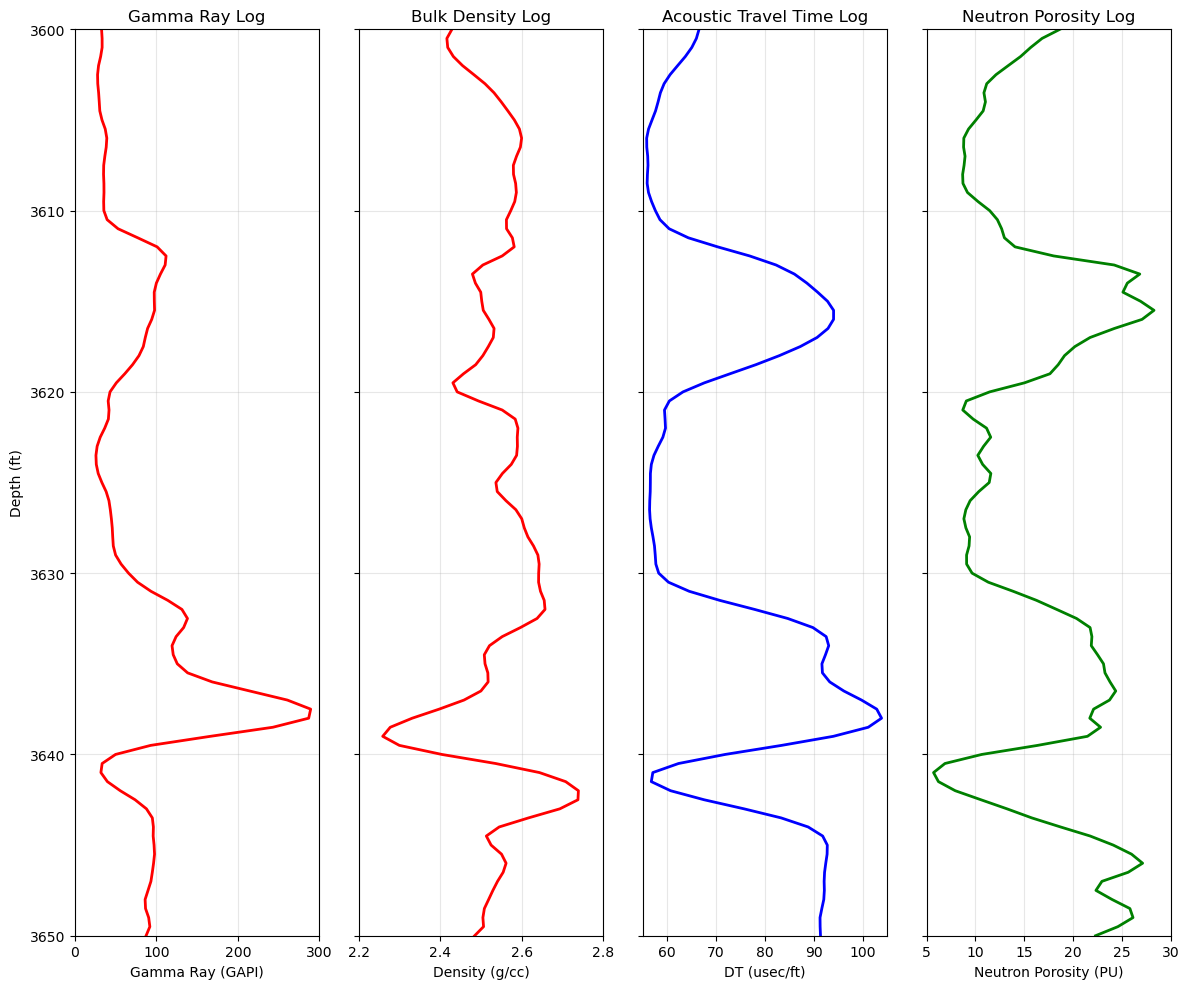

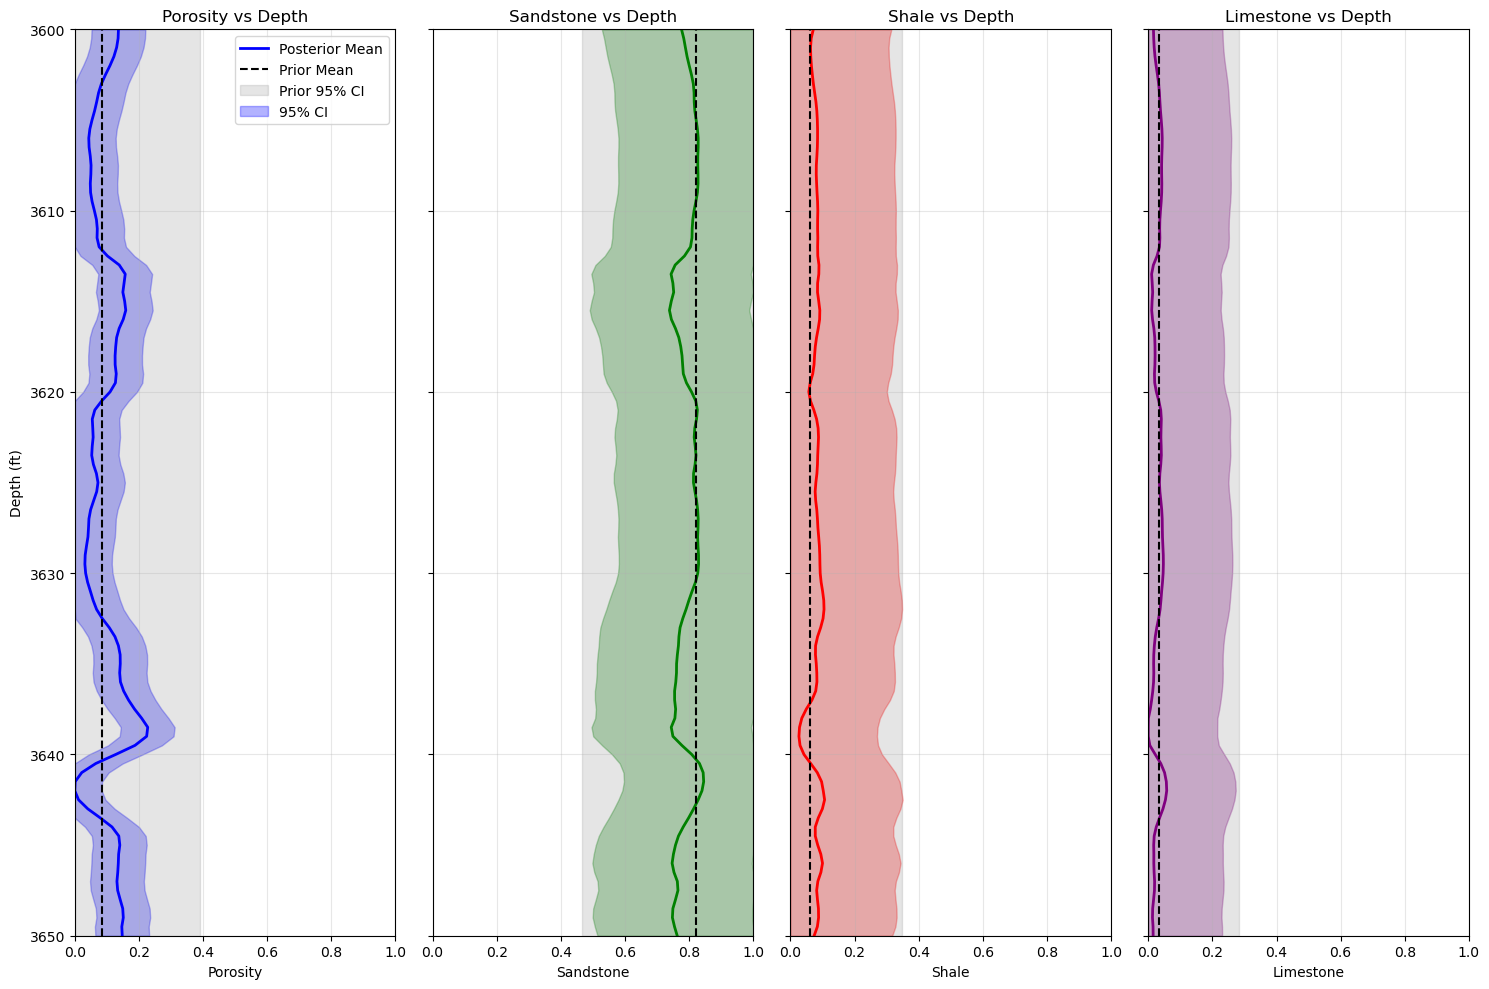

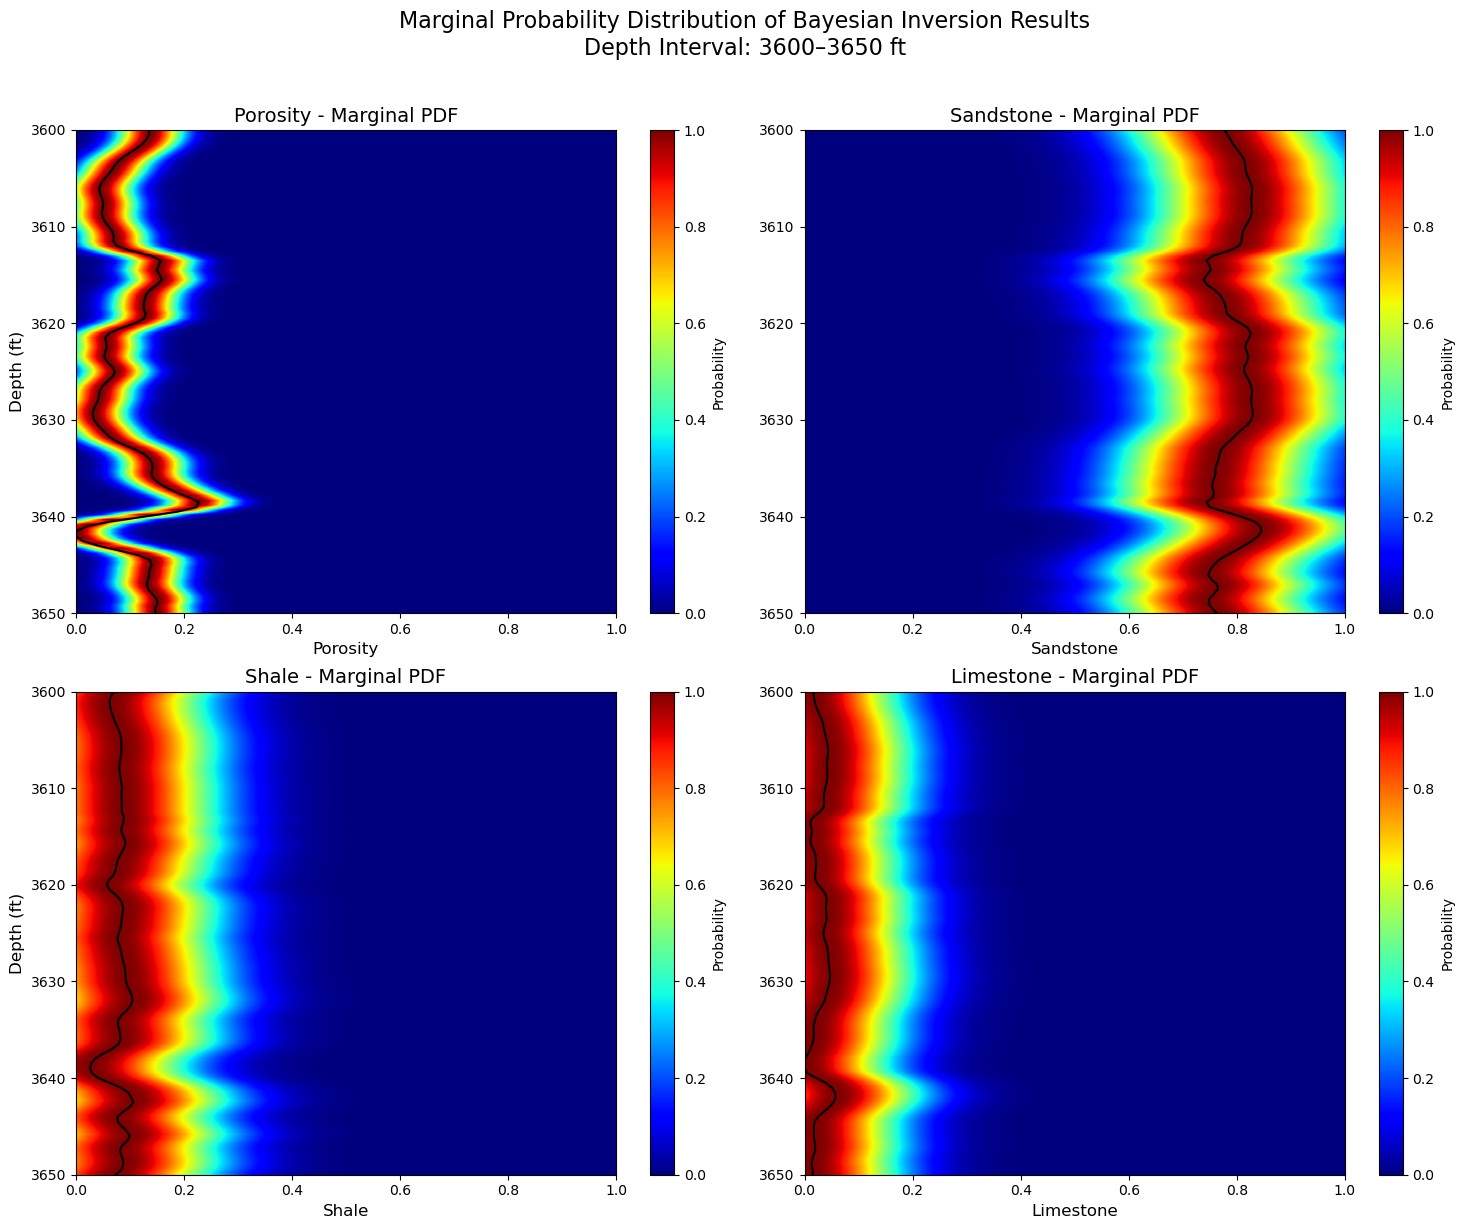

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.gridspec import GridSpec

# Load Bayesian results (from previous steps)
# If you've saved the results to a variable called 'bayesian_results'
# and have 'depth_filtered', 'density_filtered', etc. from your well logs

# Step 1: Create a DataFrame with the correct structure
def prepare_visualization_data(bayesian_results, depth_filtered, m_prior, posterior_std):
    """Prepare data for visualization with correct column naming"""
    # Create DataFrame with Bayesian results
    property_names = ["Porosity", "Sandstone", "Shale", "Limestone"]
    results_df = pd.DataFrame(bayesian_results, columns=property_names)
    
    # Add depth column with consistent naming
    results_df['Depth'] = depth_filtered
    
    # Calculate 95% confidence intervals
    for i, prop in enumerate(property_names):
        results_df[f'{prop}_lower'] = np.maximum(0, results_df[prop] - 1.96 * posterior_std[i])
        results_df[f'{prop}_upper'] = np.minimum(1, results_df[prop] + 1.96 * posterior_std[i])
    
    return results_df



def plot_bayesian_results(results_df, m_prior, prior_variances, figsize=(15, 10)):
    """Plot Bayesian inversion results for each parameter"""
    property_names = ["Porosity", "Sandstone", "Shale", "Limestone"]
    fig, axs = plt.subplots(1, 4, figsize=figsize, sharey=True)
    
    colors = ['blue', 'green', 'red', 'purple']
    
    for i, prop in enumerate(property_names):
        ax = axs[i]
        
        # Plot posterior values vs depth
        ax.plot(results_df[prop], results_df['Depth'], color=colors[i], lw=2, label='Posterior Mean')
        
        # Add uncertainty band (95% CI)
        ax.fill_betweenx(results_df['Depth'], 
                         results_df[f'{prop}_lower'], 
                         results_df[f'{prop}_upper'],
                         color=colors[i], alpha=0.3, label='95% CI')
        
        # Add prior mean and std
        prior_mean = m_prior[i]
        prior_std = np.sqrt(prior_variances[i])
        
        # Plot prior mean as vertical line
        ax.axvline(x=prior_mean, color='black', linestyle='--', label='Prior Mean')
        
        # Add prior 95% CI as vertical span
        ci_low = max(0, prior_mean - 1.96*prior_std)
        ci_high = min(1, prior_mean + 1.96*prior_std)
        ax.axvspan(ci_low, ci_high, color='gray', alpha=0.2, label='Prior 95% CI')
        
        # Set appropriate limits based on parameter
        if prop == 'Porosity':
            ax.set_xlim(0, 1.0)
        elif prop == 'Sandstone':
            ax.set_xlim(0, 1.0)
        elif prop == 'Shale':
            ax.set_xlim(0, 1.0)
        elif prop == 'Limestone':
            ax.set_xlim(0, 1.0)
        
        # Labels and title
        ax.set_xlabel(prop)
        ax.set_title(f'{prop} vs Depth')
        ax.grid(True, alpha=0.3)
        
        # Add legend only to the first plot
        if i == 0:
            ax.legend()
            ax.set_ylabel('Depth (ft)')
    
    # Set y-axis limits (depth increases downward)
    for ax in axs:
        ax.set_ylim(3650, 3600)
        
    plt.tight_layout()
    return fig

# Step 4: Marginal Probability Distribution Visualization
def plot_marginal_distributions(results_df, posterior_std, figsize=(15, 12)):
    """Create 2D heatmap visualizations of marginal posterior distributions"""
    property_names = ["Porosity", "Sandstone", "Shale", "Limestone"]
    
    # Set up grid for parameter values and depths
    param_ranges = {
        "Porosity": np.linspace(0, 1.0, 200),
        "Sandstone": np.linspace(0, 1.0, 200),
        "Shale": np.linspace(0, 1.0, 200),
        "Limestone": np.linspace(0, 1.0, 200)
    }
    
    depths = results_df['Depth'].values
    
    # Generate posterior PDFs at each depth
    pdf_grid = {}
    for i, prop in enumerate(property_names):
        values = results_df[prop].values
        std = posterior_std[i]  # Use posterior uncertainty
        
        # Create PDF grid
        param_range = param_ranges[prop]
        pdf = np.zeros((len(depths), len(param_range)))
        
        for j, v in enumerate(values):
            # Use posterior standard deviation for accurate representation
            pdf[j, :] = norm.pdf(param_range, loc=v, scale=std)
            pdf[j, :] /= np.max(pdf[j, :])  # Normalize
        
        pdf_grid[prop] = pdf
    
    # Create the plot
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    axs = axs.flatten()
    
    for i, prop in enumerate(property_names):
        ax = axs[i]
        param_range = param_ranges[prop]
        
        # Plot the marginal PDF as a heatmap
        extent = [param_range[0], param_range[-1], depths[-1], depths[0]]
        im = ax.imshow(pdf_grid[prop], aspect='auto', cmap='jet',
                       extent=extent, vmin=0, vmax=1, 
                       interpolation='bilinear')
        
        # Plot the posterior mean results as a black line
        ax.plot(results_df[prop], results_df['Depth'], 'k-', linewidth=1.5, label='Posterior Mean')
        
        # Add labels and customize plot
        ax.set_title(f"{prop} - Marginal PDF", fontsize=14)
        ax.set_xlabel(prop, fontsize=12)
        ax.set_ylabel("Depth (ft)" if i % 2 == 0 else "", fontsize=12)
        
        # Add colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Probability", fontsize=10)
    
    plt.tight_layout()
    plt.suptitle("Marginal Probability Distribution of Bayesian Inversion Results\nDepth Interval: 3600–3650 ft", 
                 y=1.02, fontsize=16)
    plt.subplots_adjust(top=0.92)
    
    return fig

# Step 5: Main function to generate all plots
def visualize_petrophysical_analysis(bayesian_results, depth_filtered, density_filtered, 
                                    dt_filtered, cnpor_filtered, gr_filtered,
                                    m_prior, prior_variances, posterior_std):
    """Generate all visualizations for the petrophysical analysis"""
    
    # Prepare data
    results_df = prepare_visualization_data(bayesian_results, depth_filtered, m_prior, posterior_std)
    
    # Plot well logs
    log_fig = plot_well_logs(depth_filtered, gr_filtered, density_filtered, dt_filtered, cnpor_filtered)
    log_fig.savefig('well_logs.png', dpi=300, bbox_inches='tight')
    
    # Plot Bayesian inversion results
    bayesian_fig = plot_bayesian_results(results_df, m_prior, prior_variances)
    bayesian_fig.savefig('bayesian_results.png', dpi=300, bbox_inches='tight')
    
    # Plot marginal distributions
    marginal_fig = plot_marginal_distributions(results_df, posterior_std)
    marginal_fig.savefig('marginal_distributions.png', dpi=300, bbox_inches='tight')
    
    print("All visualizations generated successfully!")
    return log_fig, bayesian_fig, marginal_fig

# Execute the visualization (assuming you have the variables from previous steps)
# If you don't have all these variables defined, you'll need to run your Bayesian inversion first
try:
    log_fig, bayesian_fig, marginal_fig = visualize_petrophysical_analysis(
        bayesian_results, depth_filtered, density_filtered, dt_filtered, 
        cnpor_filtered, gr_filtered, m_prior, prior_variances, posterior_std)
except NameError as e:
    print(f"Error: {e}. You need to run your Bayesian inversion before visualization.")
    print("Make sure you have defined: bayesian_results, depth_filtered, density_filtered, etc.")
